(Reliability Statistics and Predictive Calibration)=
# Reliability Statistics and Predictive Calibration

:::{post} January, 2023
:tags: time-to-failure, prediction, calibration, survival analysis, censored
:category: intermediate
:author: Nathaniel Forde
:::

In [1]:
import os
import random

from io import StringIO

import arviz as az
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from lifelines import KaplanMeierFitter, LogNormalFitter, WeibullFitter
from lifelines.utils import survival_table_from_events
from scipy.stats import binom, lognorm, norm, weibull_min

In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = 'retina'

## Reliability Statistics 

When we want to make inferences about likely failures on a production line,  we may have large or small sample data set depending on the industry, nature of the goods or specificifty of the question we're seeking to answer. But in all cases there is a question of cost and a quantity of tolerable failures.  

A reliability study therefore has to account for the period in which a failure is important to observe, the cost of the failure and cost of running a mis-specified study. The requirements for precision in the definition of the question and the nature of the modelling exercise are paramount. 

The key feature of time-to-failure data is the manner in which it is censored and how this biases traditional statistical summaries and estimation techniques. In this notebook we're going to focus on the prediction of failure times and compare the Bayesian notion of a calibrated prediction interval to some frequentist alternatives. We draw on the work in the book *Statistical Methods for Reliability Data*. See (see {cite:t}`Meeker2021`)

### Types of Prediction

We might want to know about different views of the failure time distribution such as:

- Time to failure of a new item
- Time until k failures in a future sample of m units

While there are non-parametric and descriptive methods that can be used to assess these kinds of question we're going to focus on the case where we have a probability model e.g. a lognormal distribution of failure times $F(t: \mathbf{\theta})$ parameterised by an unknown $\mathbf{\theta}$.

### Structure of the Presentation

We will 

- Discuss non-parametric estimates of the cumulative density function CDF for reliability data
- Show how a frequentist or MLE of the same function can be derived to inform our prediction interval
- Show how Bayesian methods can be used to augment the analysis of the same CDF in cases with sparse information. 

Throughout the focus will be how the understanding of the CDF can help us understand risk of failure in a reliability setting. In particular how the CDF can be used to derive a well calibrated prediction interval.

### Example Failure Distribution

In the study of reliability statistics there is a focus on location-scale based distributions with long tails. In an ideal world we'd know exactly which distribution described our failure process and the prediction interval for the next failure could be defined exactly.

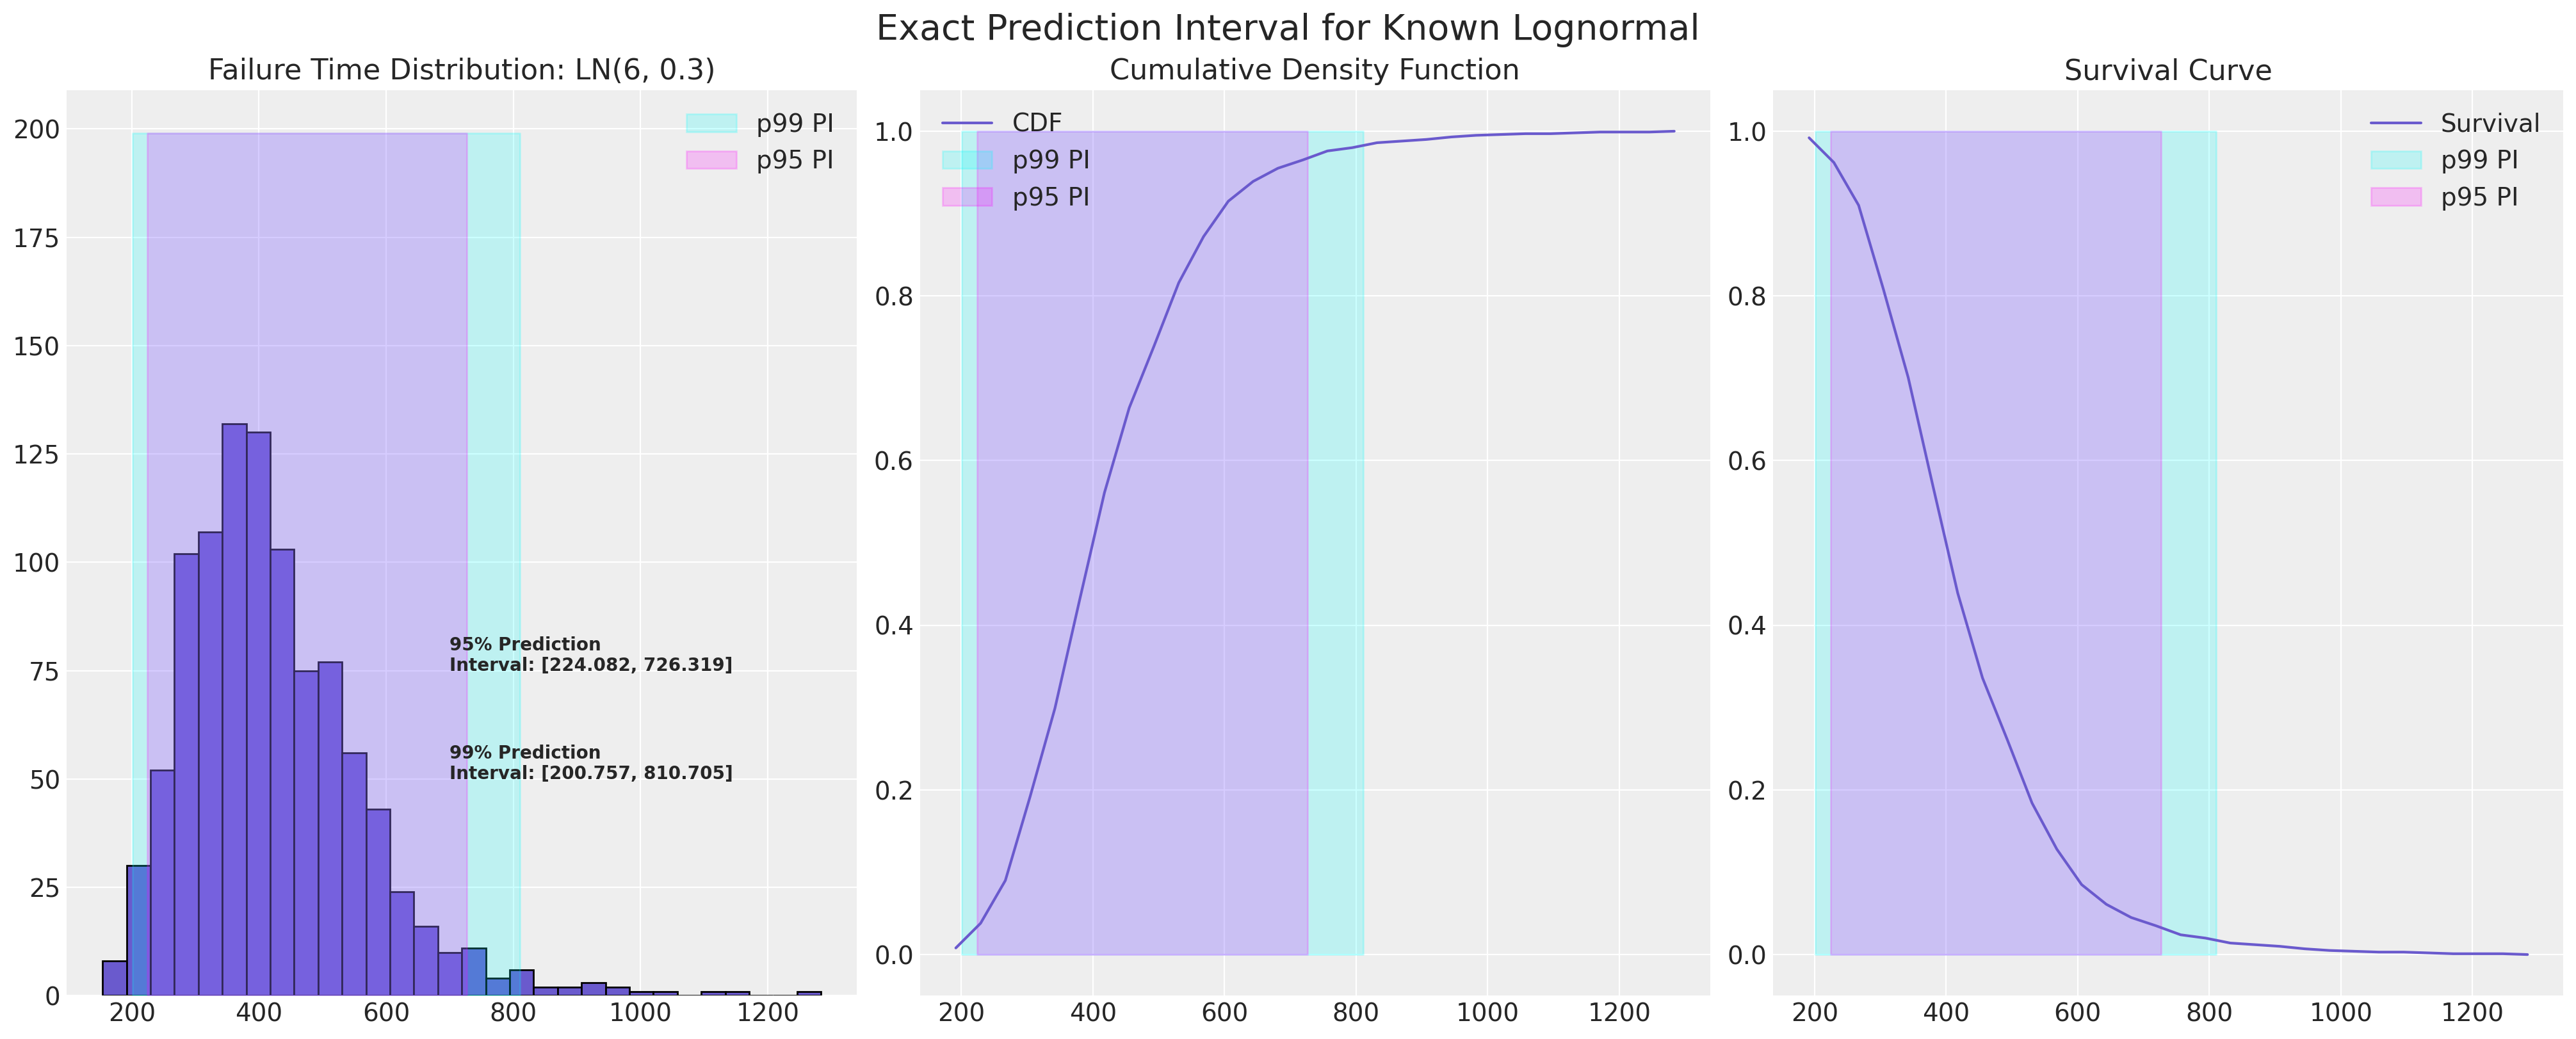

In [3]:
mu, sigma = 6, 0.3


def plot_ln_pi(mu, sigma, xy=(700, 75), title="Exact Prediction Interval for Known Lognormal"):
    failure_dist = lognorm(s=sigma, scale=np.exp(mu))
    samples = failure_dist.rvs(size=1000, random_state=100)
    fig, axs = plt.subplots(1, 3, figsize=(20, 8))
    axs = axs.flatten()
    axs[0].hist(samples, ec="black", color="slateblue", bins=30)
    axs[0].set_title(f"Failure Time Distribution: LN({mu}, {sigma})")
    count, bins_count = np.histogram(samples, bins=30)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    axs[1].plot(bins_count[1:], cdf, label="CDF", color="slateblue")
    axs[2].plot(bins_count[1:], 1 - cdf, label="Survival", color="slateblue")
    axs[2].legend()
    axs[1].legend()
    axs[1].set_title("Cumulative Density Function")
    axs[2].set_title("Survival Curve")

    lb = failure_dist.ppf(0.01)
    ub = failure_dist.ppf(0.99)
    axs[0].annotate(
        f"99% Prediction \nInterval: [{np.round(lb, 3)}, {np.round(ub, 3)}]",
        xy=(xy[0], xy[1] - 25),
        fontweight="bold",
    )
    axs[0].fill_betweenx(y=range(200), x1=lb, x2=ub, alpha=0.2, label="p99 PI", color="cyan")
    axs[1].fill_betweenx(y=range(2), x1=lb, x2=ub, alpha=0.2, label="p99 PI", color="cyan")
    axs[2].fill_betweenx(y=range(2), x1=lb, x2=ub, alpha=0.2, label="p99 PI", color="cyan")
    lb = failure_dist.ppf(0.025)
    ub = failure_dist.ppf(0.975)
    axs[0].annotate(
        f"95% Prediction \nInterval: [{np.round(lb, 3)}, {np.round(ub, 3)}]",
        xy=(xy[0], xy[1]),
        fontweight="bold",
    )
    axs[0].fill_betweenx(y=range(200), x1=lb, x2=ub, alpha=0.2, label="p95 PI", color="magenta")
    axs[1].fill_betweenx(y=range(2), x1=lb, x2=ub, alpha=0.2, label="p95 PI", color="magenta")
    axs[2].fill_betweenx(y=range(2), x1=lb, x2=ub, alpha=0.2, label="p95 PI", color="magenta")
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()
    plt.suptitle(title, fontsize=20)


plot_ln_pi(mu, sigma)

## Estimation of the Failure Distribution from Data

In the real world we rarely have such exact knowledge. Instead we start with altogether less clear data. We will first examine failure data about heat exchanges across three plants and pool the information to quantify the lifetime of the heat-exchanges over the three factories. 

The data is small deliberately so we can focus on the descriptive statistics involved in assessing time-to-failure data. In particular we'll estimate the empirical CDF and survival functions. We will then generalise this style of analysis to a larger data set afterwards. 

### Heat Exchange Data

**Note on Censored Data**:
See below how the failure data flags whether or not an observation has been censored i.e. whether or not we have observed the full course of the life-time of the heat-exchanger. This is a crucial feature of failure time data. Too simple a statistical summary will be biased in its estimation of the prevalance of failure by the fact that our study has not seen out the full-course of every item's life-cycle. The most prevalent form of censoring is so called "Right censored" data where we have not seen the "failure" event for a subset of the observations. Our histories are incomplete due to prematurely ending the data collection. 

Left censoring (where we don't observe an item from the beginning of their history) and interval censoring (both left and right censoring) can also occur but are less common.

In [4]:
heat_exchange_df = pd.read_csv(
    StringIO(
        """Years Lower,Years Upper,Censoring Indicator,Count,Plant
0,1,Left,1,1
1,2,Interval,2,1
2,3,Interval,2,1
3, ,Right,95,1
0,1,Left,2,2
1,2,Interval,3,2
2, ,Right,95,2
0,1,Left,1,3
1, ,Right,99,3

"""
    )
)

heat_exchange_df["year_interval"] = (
    heat_exchange_df["Years Lower"].astype(str) + "," + heat_exchange_df["Years Upper"].astype(str)
)
heat_exchange_df["failed"] = np.where(
    heat_exchange_df["Censoring Indicator"] != "Right", heat_exchange_df["Count"], 0
)
heat_exchange_df["censored"] = np.where(
    heat_exchange_df["Censoring Indicator"] == "Right", heat_exchange_df["Count"], 0
)
heat_exchange_df["risk_set"] = [100, 99, 97, 0, 100, 98, 0, 100, 0]
heat_exchange_df

Years Lower Years Upper Censoring Indicator  Count  Plant year_interval  \
0            0           1                Left      1      1           0,1   
1            1           2            Interval      2      1           1,2   
2            2           3            Interval      2      1           2,3   
3            3                           Right     95      1           3,    
4            0           1                Left      2      2           0,1   
5            1           2            Interval      3      2           1,2   
6            2                           Right     95      2           2,    
7            0           1                Left      1      3           0,1   
8            1                           Right     99      3           1,    

   failed  censored  risk_set  
0       1         0       100  
1       2         0        99  
2       2         0        97  
3       0        95         0  
4       2         0       100  
5       3         0        98  
6       0        95         0  
7       1         0       100  
8       0        99         0

In [5]:
actuarial_table = heat_exchange_df.groupby(["Years Upper"])[["failed", "risk_set"]].sum()
actuarial_table = actuarial_table.tail(3)


def greenwood_variance(df):
    ### Used to estimate the variance in the CDF
    n = len(df)
    ps = [df.iloc[i]["p_hat"] / (df.iloc[i]["risk_set"] * df.iloc[i]["1-p_hat"]) for i in range(n)]
    s = [(df.iloc[i]["S_hat"] ** 2) * np.sum(ps[0 : i + 1]) for i in range(n)]
    return s


def logit_transform_interval(df):
    ### Used for robustness in the estimation of the Confidence intervals in the CDF
    df["logit_CI_95_lb"] = df["F_hat"] / (
        df["F_hat"]
        + df["S_hat"] * np.exp((1.960 * df["Standard_Error"]) / (df["F_hat"] * df["S_hat"]))
    )
    df["logit_CI_95_ub"] = df["F_hat"] / (
        df["F_hat"]
        + df["S_hat"] / np.exp((1.960 * df["Standard_Error"]) / (df["F_hat"] * df["S_hat"]))
    )
    df["logit_CI_95_lb"] = np.where(df["logit_CI_95_lb"] < 0, 0, df["logit_CI_95_lb"])
    df["logit_CI_95_ub"] = np.where(df["logit_CI_95_ub"] > 1, 1, df["logit_CI_95_ub"])
    return df


def make_actuarial_table(actuarial_table):
    ### Actuarial lifetables are used to describe the nature of the risk over time and estimate
    actuarial_table["p_hat"] = actuarial_table["failed"] / actuarial_table["risk_set"]
    actuarial_table["1-p_hat"] = 1 - actuarial_table["p_hat"]
    actuarial_table["S_hat"] = actuarial_table["1-p_hat"].cumprod()
    actuarial_table["CH_hat"] = -np.log(actuarial_table["S_hat"])
    ### The Estimate of the CDF function
    actuarial_table["F_hat"] = 1 - actuarial_table["S_hat"]
    actuarial_table["V_hat"] = greenwood_variance(actuarial_table)
    actuarial_table["Standard_Error"] = np.sqrt(actuarial_table["V_hat"])
    actuarial_table["CI_95_lb"] = (
        actuarial_table["F_hat"] - actuarial_table["Standard_Error"] * 1.960
    )
    actuarial_table["CI_95_lb"] = np.where(
        actuarial_table["CI_95_lb"] < 0, 0, actuarial_table["CI_95_lb"]
    )
    actuarial_table["CI_95_ub"] = (
        actuarial_table["F_hat"] + actuarial_table["Standard_Error"] * 1.960
    )
    actuarial_table["CI_95_ub"] = np.where(
        actuarial_table["CI_95_ub"] > 1, 1, actuarial_table["CI_95_ub"]
    )
    actuarial_table["ploting_position"] = actuarial_table["F_hat"].rolling(1).median()
    actuarial_table = logit_transform_interval(actuarial_table)
    return actuarial_table


actuarial_table_heat = make_actuarial_table(actuarial_table)
actuarial_table_heat = actuarial_table_heat.reset_index()
actuarial_table_heat.rename({"Years Upper": "t"}, axis=1, inplace=True)
actuarial_table_heat["t"] = actuarial_table_heat["t"].astype(int)
actuarial_table_heat

t  failed  risk_set     p_hat   1-p_hat     S_hat    CH_hat     F_hat  \
0  1       4       300  0.013333  0.986667  0.986667  0.013423  0.013333   
1  2       5       197  0.025381  0.974619  0.961624  0.039131  0.038376   
2  3       2        97  0.020619  0.979381  0.941797  0.059965  0.058203   

      V_hat  Standard_Error  CI_95_lb  CI_95_ub  ploting_position  \
0  0.000044        0.006622  0.000354  0.026313          0.013333   
1  0.000164        0.012802  0.013283  0.063468          0.038376   
2  0.000350        0.018701  0.021550  0.094856          0.058203   

   logit_CI_95_lb  logit_CI_95_ub  
0        0.005013        0.034977  
1        0.019818        0.073016  
2        0.030694        0.107629

It's worth taking some time to walk through this example because it establishes estimates of some key quantities in time-to-failure modelling. 

First note how we're treating time as a series of discrete intervals. The data format is in discrete **period format**, since it records aggregate failures over time. We'll see below another format of failure data - the **item-period** format which records each individual item over all periods and their corresponding status. In this format the key quantities are the set of `failed` items and the `risk_set` in each period. Everything else is derived from these facts. 

First we've established across all three companies in three consecutive years the number of heat-exchanges that were produced and subsequently `failed`. This provides an estimate of the probability of failure in the year: `p_hat` and its inverse `1-p_hat` respectively. These are further combined over the course of the year to estimate the survival curve `S_hat` which can be further transformed to recover estimates of the cumulative hazard `CH_hat` and the cumulative density function `F_hat`. 

Next we want a quick a dirty way to quantify the extent of the uncertainty in our estimate of the CDF. For this purpose we use greenwood's formula to estimate the variance of our `V_hat` of our estimate `F_hat`. This gives us the standard error and the two varieties of confidence interval recommended in the literature. 

We' apply the same techniques to a larger dataset and plot some of these quantities below. 

### The Shock Absorbers Data: A Study in Frequentist Reliability Analysis

The shock absorbers data is in period format but it records a constantly decreasing risk set over time with one item being censored or failing at each time point i.e. removed from testing successfully (approved) or removed due to failure. This is a special case of the **period** format data.

In [6]:
shockabsorbers_df = pd.read_csv(
    StringIO(
        """Kilometers,Failure Mode,Censoring Indicator
6700,Mode1,Failed
6950,Censored,Censored
7820,Censored,Censored
8790,Censored,Censored
9120,Mode2,Failed
9660,Censored,Censored
9820,Censored,Censored
11310,Censored,Censored
11690,Censored,Censored
11850,Censored,Censored
11880,Censored,Censored
12140,Censored,Censored
12200,Mode1,Failed
12870,Censored,Censored
13150,Mode2,Failed
13330,Censored,Censored
13470,Censored,Censored
14040,Censored,Censored
14300,Mode1,Failed
17520,Mode1,Failed
17540,Censored,Censored
17890,Censored,Censored
18450,Censored,Censored
18960,Censored,Censored
18980,Censored,Censored
19410,Censored,Censored
20100,Mode2,Failed
20100,Censored,Censored
20150,Censored,Censored
20320,Censored,Censored
20900,Mode2,Failed
22700,Mode1,Failed
23490,Censored,Censored
26510,Mode1,Failed
27410,Censored,Censored
27490,Mode1,Failed
27890,Censored,Censored
28100,Censored,Censored
"""
    )
)

shockabsorbers_df["failed"] = np.where(shockabsorbers_df["Censoring Indicator"] == "Failed", 1, 0)
shockabsorbers_df["t"] = shockabsorbers_df["Kilometers"]
shockabsorbers_events = survival_table_from_events(
    shockabsorbers_df["t"], shockabsorbers_df["failed"]
).reset_index()
shockabsorbers_events.rename(
    {"event_at": "t", "observed": "failed", "at_risk": "risk_set"}, axis=1, inplace=True
)
actuarial_table_shock = make_actuarial_table(shockabsorbers_events)
actuarial_table_shock

t  removed  failed  censored  entrance  risk_set     p_hat  \
0       0.0        0       0         0        38        38  0.000000   
1    6700.0        1       1         0         0        38  0.026316   
2    6950.0        1       0         1         0        37  0.000000   
3    7820.0        1       0         1         0        36  0.000000   
4    8790.0        1       0         1         0        35  0.000000   
5    9120.0        1       1         0         0        34  0.029412   
6    9660.0        1       0         1         0        33  0.000000   
7    9820.0        1       0         1         0        32  0.000000   
8   11310.0        1       0         1         0        31  0.000000   
9   11690.0        1       0         1         0        30  0.000000   
10  11850.0        1       0         1         0        29  0.000000   
11  11880.0        1       0         1         0        28  0.000000   
12  12140.0        1       0         1         0        27  0.000000   
13  12200.0        1       1         0         0        26  0.038462   
14  12870.0        1       0         1         0        25  0.000000   
15  13150.0        1       1         0         0        24  0.041667   
16  13330.0        1       0         1         0        23  0.000000   
17  13470.0        1       0         1         0        22  0.000000   
18  14040.0        1       0         1         0        21  0.000000   
19  14300.0        1       1         0         0        20  0.050000   
20  17520.0        1       1         0         0        19  0.052632   
21  17540.0        1       0         1         0        18  0.000000   
22  17890.0        1       0         1         0        17  0.000000   
23  18450.0        1       0         1         0        16  0.000000   
24  18960.0        1       0         1         0        15  0.000000   
25  18980.0        1       0         1         0        14  0.000000   
26  19410.0        1       0         1         0        13  0.000000   
27  20100.0        2       1         1         0        12  0.083333   
28  20150.0        1       0         1         0        10  0.000000   
29  20320.0        1       0         1         0         9  0.000000   
30  20900.0        1       1         0         0         8  0.125000   
31  22700.0        1       1         0         0         7  0.142857   
32  23490.0        1       0         1         0         6  0.000000   
33  26510.0        1       1         0         0         5  0.200000   
34  27410.0        1       0         1         0         4  0.000000   
35  27490.0        1       1         0         0         3  0.333333   
36  27890.0        1       0         1         0         2  0.000000   
37  28100.0        1       0         1         0         1  0.000000   

     1-p_hat     S_hat    CH_hat     F_hat     V_hat  Standard_Error  \
0   1.000000  1.000000 -0.000000  0.000000  0.000000        0.000000   
1   0.973684  0.973684  0.026668  0.026316  0.000674        0.025967   
2   1.000000  0.973684  0.026668  0.026316  0.000674        0.025967   
3   1.000000  0.973684  0.026668  0.026316  0.000674        0.025967   
4   1.000000  0.973684  0.026668  0.026316  0.000674        0.025967   
5   0.970588  0.945046  0.056521  0.054954  0.001431        0.037831   
6   1.000000  0.945046  0.056521  0.054954  0.001431        0.037831   
7   1.000000  0.945046  0.056521  0.054954  0.001431        0.037831   
8   1.000000  0.945046  0.056521  0.054954  0.001431        0.037831   
9   1.000000  0.945046  0.056521  0.054954  0.001431        0.037831   
10  1.000000  0.945046  0.056521  0.054954  0.001431        0.037831   
11  1.000000  0.945046  0.056521  0.054954  0.001431        0.037831   
12  1.000000  0.945046  0.056521  0.054954  0.001431        0.037831   
13  0.961538  0.908698  0.095742  0.091302  0.002594        0.050927   
14  1.000000  0.908698  0.095742  0.091302  0.002594        0.050927   
15  0.958333  0.870836  0.138302  0.129164  0.003

### Maximum Likelihood Fits for Failure Data

In addition to taking descriptive summaries of our data we can use the life-table data to estimate a univariate model fit to our distribution of failure times. Such a fit, if good, would enable us to have a clearer view of the predictive distribution a particular set of predictive intervals. Here we'll use the functions from the  `lifelines` package to estimate the MLE fit on right-censored data.

In [7]:
lnf = LogNormalFitter().fit(actuarial_table_shock["t"] + 1e-25, actuarial_table_shock["failed"])
lnf.print_summary()

<lifelines.LogNormalFitter:"LogNormal_estimate", fitted with 38 total observations, 27 right-censored observations>
   number of observations = 38
number of events observed = 11
           log-likelihood = -124.20
               hypothesis = mu_ != 0, sigma_ != 1

---
         coef   se(coef)   coef lower 95%   coef upper 95%
mu_     10.13       0.14             9.85            10.41
sigma_   0.53       0.11             0.31             0.74

         cmp to     z      p   -log2(p)
mu_        0.00 71.08 <0.005        inf
sigma_     1.00 -4.26 <0.005      15.58
---
AIC = 252.41

Although it's tempting to take this model and run with it, we need to be cautious in the case of limited data. For instance in the heat-exchange data we have three years of data with a total of 11 failures. A too simple model can get this quite wrong. For the moment we'll focus on the shock-absorber data - its non-parametric description and a simple univariate fit to this data.

In [8]:
def plot_cdfs(actuarial_table, dist_fits=True, ax=None, title="", xy=(3000, 0.5), item_period=None):
    if item_period is None:
        lnf = LogNormalFitter().fit(actuarial_table["t"] + 1e-25, actuarial_table["failed"])
        wbf = WeibullFitter().fit(actuarial_table["t"] + 1e-25, actuarial_table["failed"])
    else:
        lnf = LogNormalFitter().fit(item_period["t"] + 1e-25, item_period["failed"])
        wbf = WeibullFitter().fit(item_period["t"] + 1e-25, item_period["failed"])
    if ax is None:
        fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(
        actuarial_table["t"],
        actuarial_table["F_hat"],
        "-o",
        color="black",
        label="Non-Parametric Estimate of CDF",
    )
    ax.plot(
        actuarial_table["t"],
        actuarial_table["CI_95_lb"],
        color="darkorchid",
        linestyle="--",
        label="Non-Parametric 95% CI based on Normal Approx",
    )
    ax.plot(actuarial_table["t"], actuarial_table["CI_95_ub"], color="darkorchid", linestyle="--")
    ax.fill_between(
        actuarial_table["t"],
        actuarial_table["CI_95_lb"],
        actuarial_table["CI_95_ub"],
        color="darkorchid",
        alpha=0.2,
    )
    ax.plot(
        actuarial_table["t"],
        actuarial_table["logit_CI_95_lb"],
        color="royalblue",
        linestyle="--",
        label="Non-Parametric 95% CI based on Logit Approx",
    )
    ax.plot(
        actuarial_table["t"], actuarial_table["logit_CI_95_ub"], color="royalblue", linestyle="--"
    )
    ax.fill_between(
        actuarial_table["t"],
        actuarial_table["logit_CI_95_lb"],
        actuarial_table["logit_CI_95_ub"],
        color="royalblue",
        alpha=0.2,
    )
    if dist_fits:
        lnf.plot_cumulative_density(ax=ax, color="crimson", alpha=0.8)
        wbf.plot_cumulative_density(ax=ax, color="cyan", alpha=0.8)
        ax.annotate(
            f"Lognormal Fit: mu = {np.round(lnf.mu_, 3)}, sigma = {np.round(lnf.sigma_, 3)} \nWeibull Fit: lambda = {np.round(wbf.lambda_, 3)}, rho = {np.round(wbf.rho_, 3)}",
            xy=(xy[0], xy[1]),
            fontsize=12,
            weight="bold",
        )
    ax.set_title(
        f"Estimates of the Cumulative Density Function \n derived from our {title} Failure Data",
        fontsize=20,
    )
    ax.set_ylabel("Fraction Failing")
    ax.set_xlabel("Time Scale")
    ax.legend()
    return ax

<AxesSubplot: title={'center': 'Estimates of the Cumulative Density Function \n derived from our Shock Absorber Failure Data'}, xlabel='Time Scale', ylabel='Fraction Failing'>

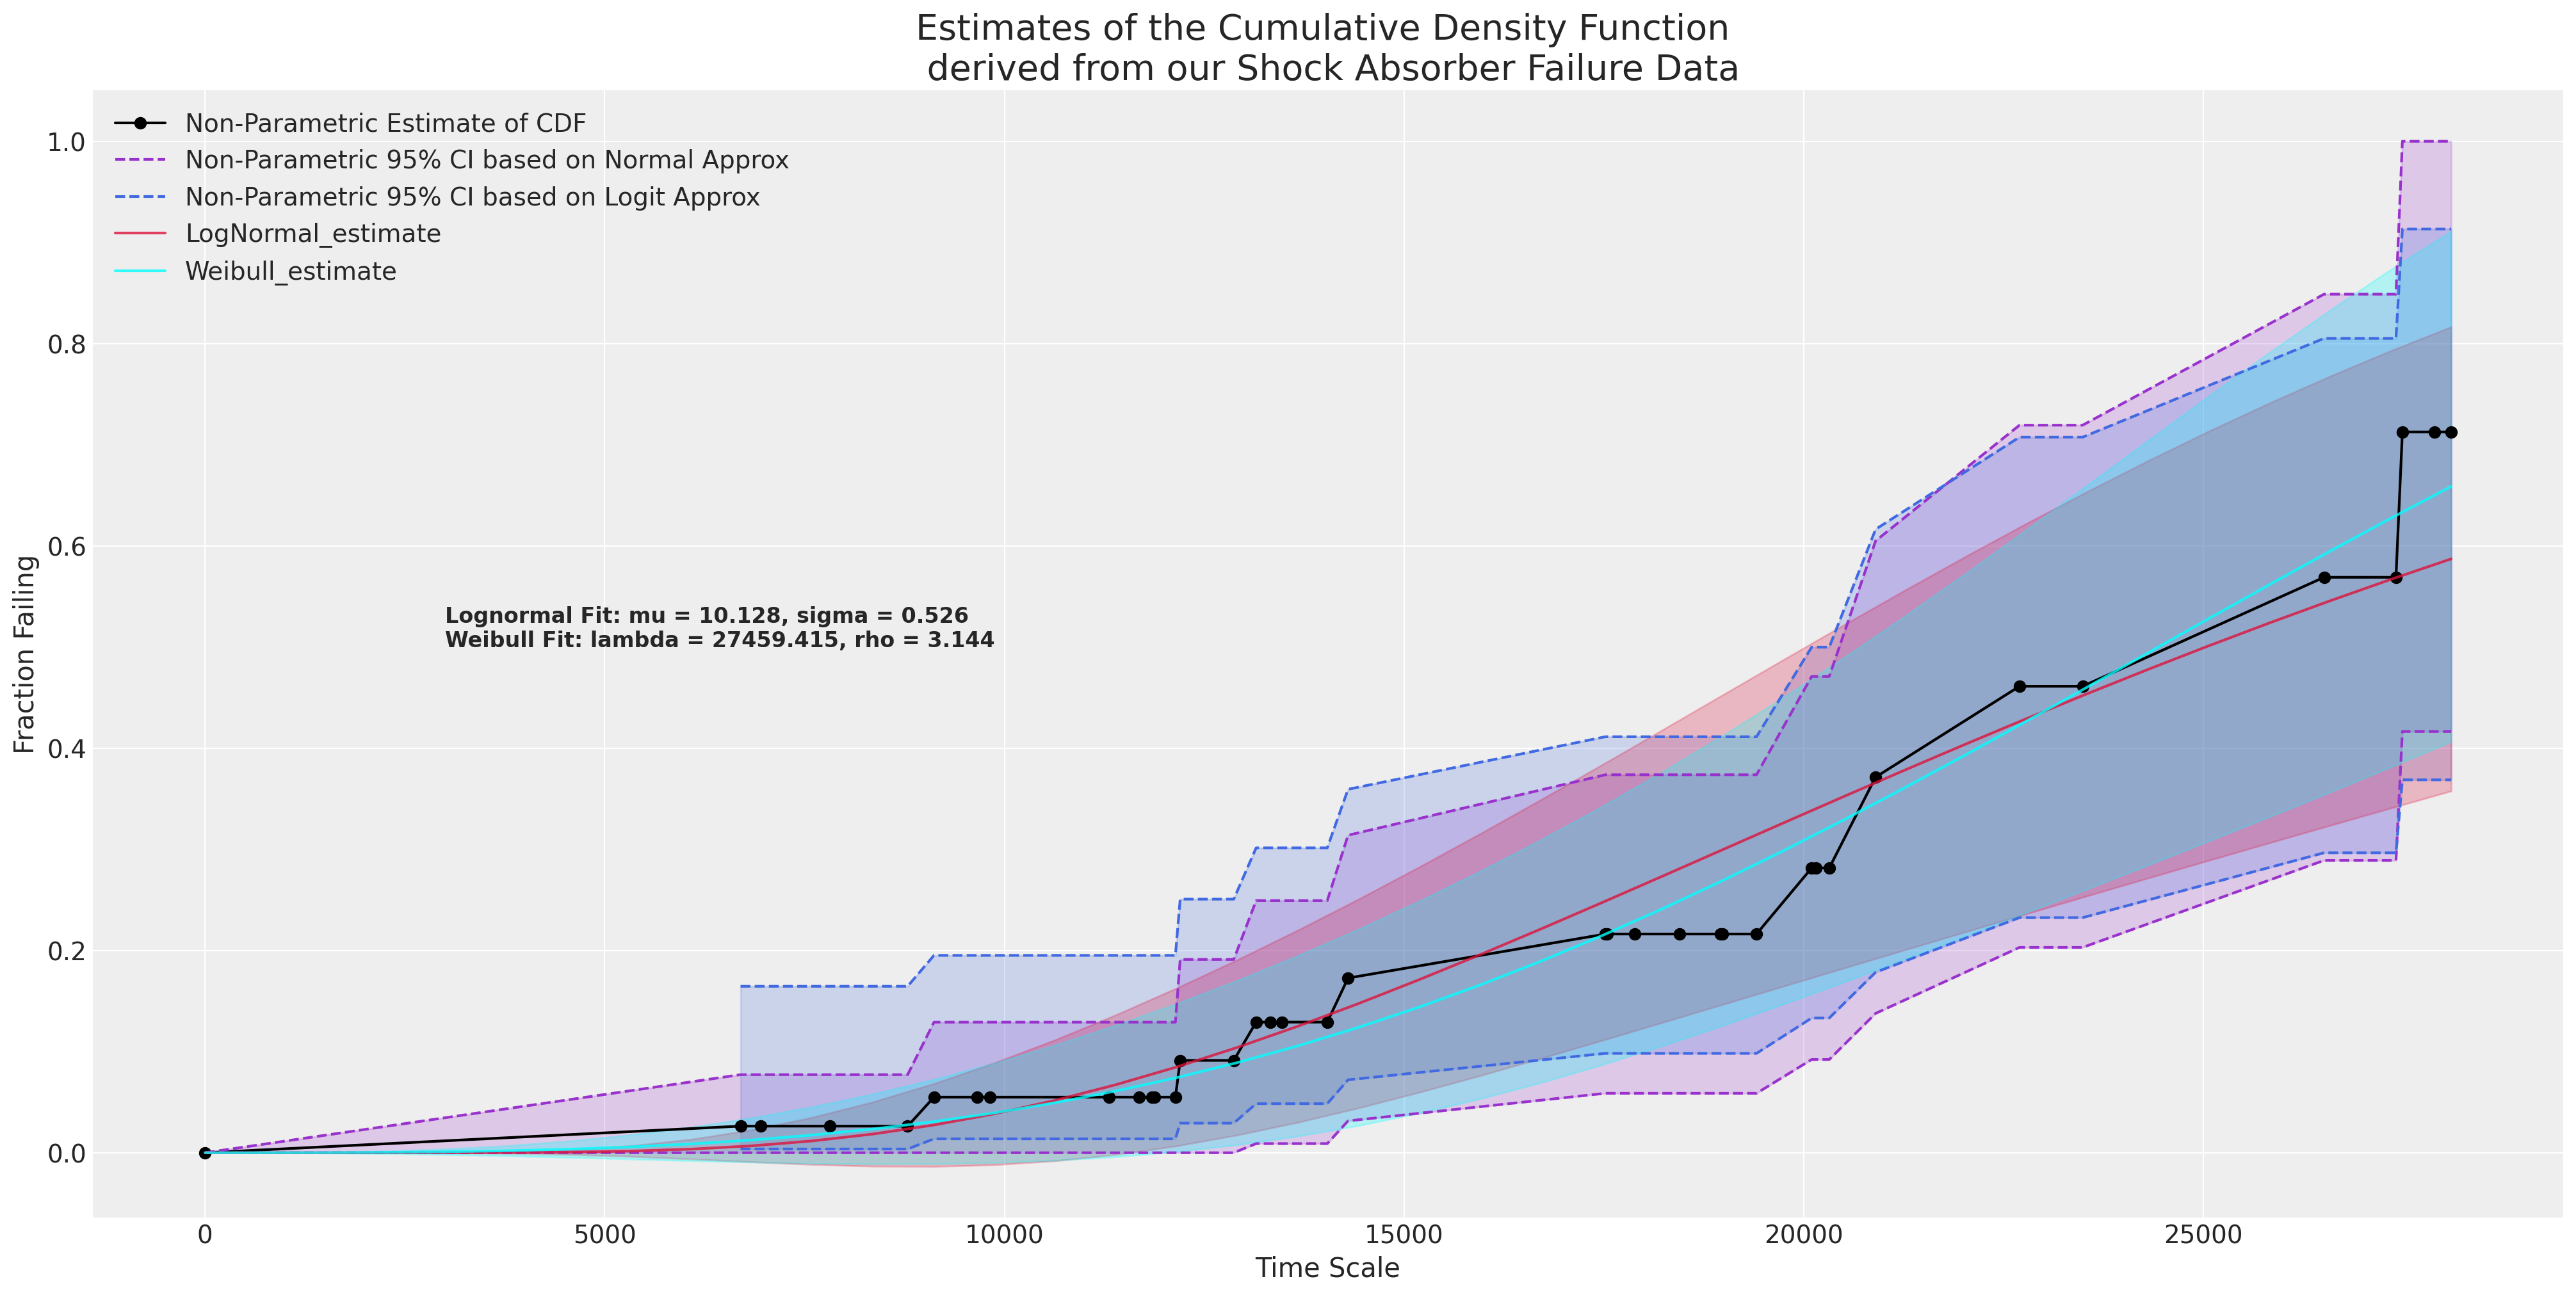

In [9]:
plot_cdfs(actuarial_table_shock, title="Shock Absorber")

This shows a good fit to the data and implies, as you might expect, that the failing fraction of shock absorbers increases with age as they wear out. But how do we quantify the prediction given an estimated model?

## The Plug-in-Procedure for calculating Approximate Statistical Prediction Intervals

Since we've estimated a lognormal fit for the CDF of the shock absorbers data we can plot their approximate prediction interval. The interest here is likely to be in the lower bound of the prediction interval since we as manufacturers might want to be aware of warranty claims and the risk of exposure to refunds if the lower bound is too low.

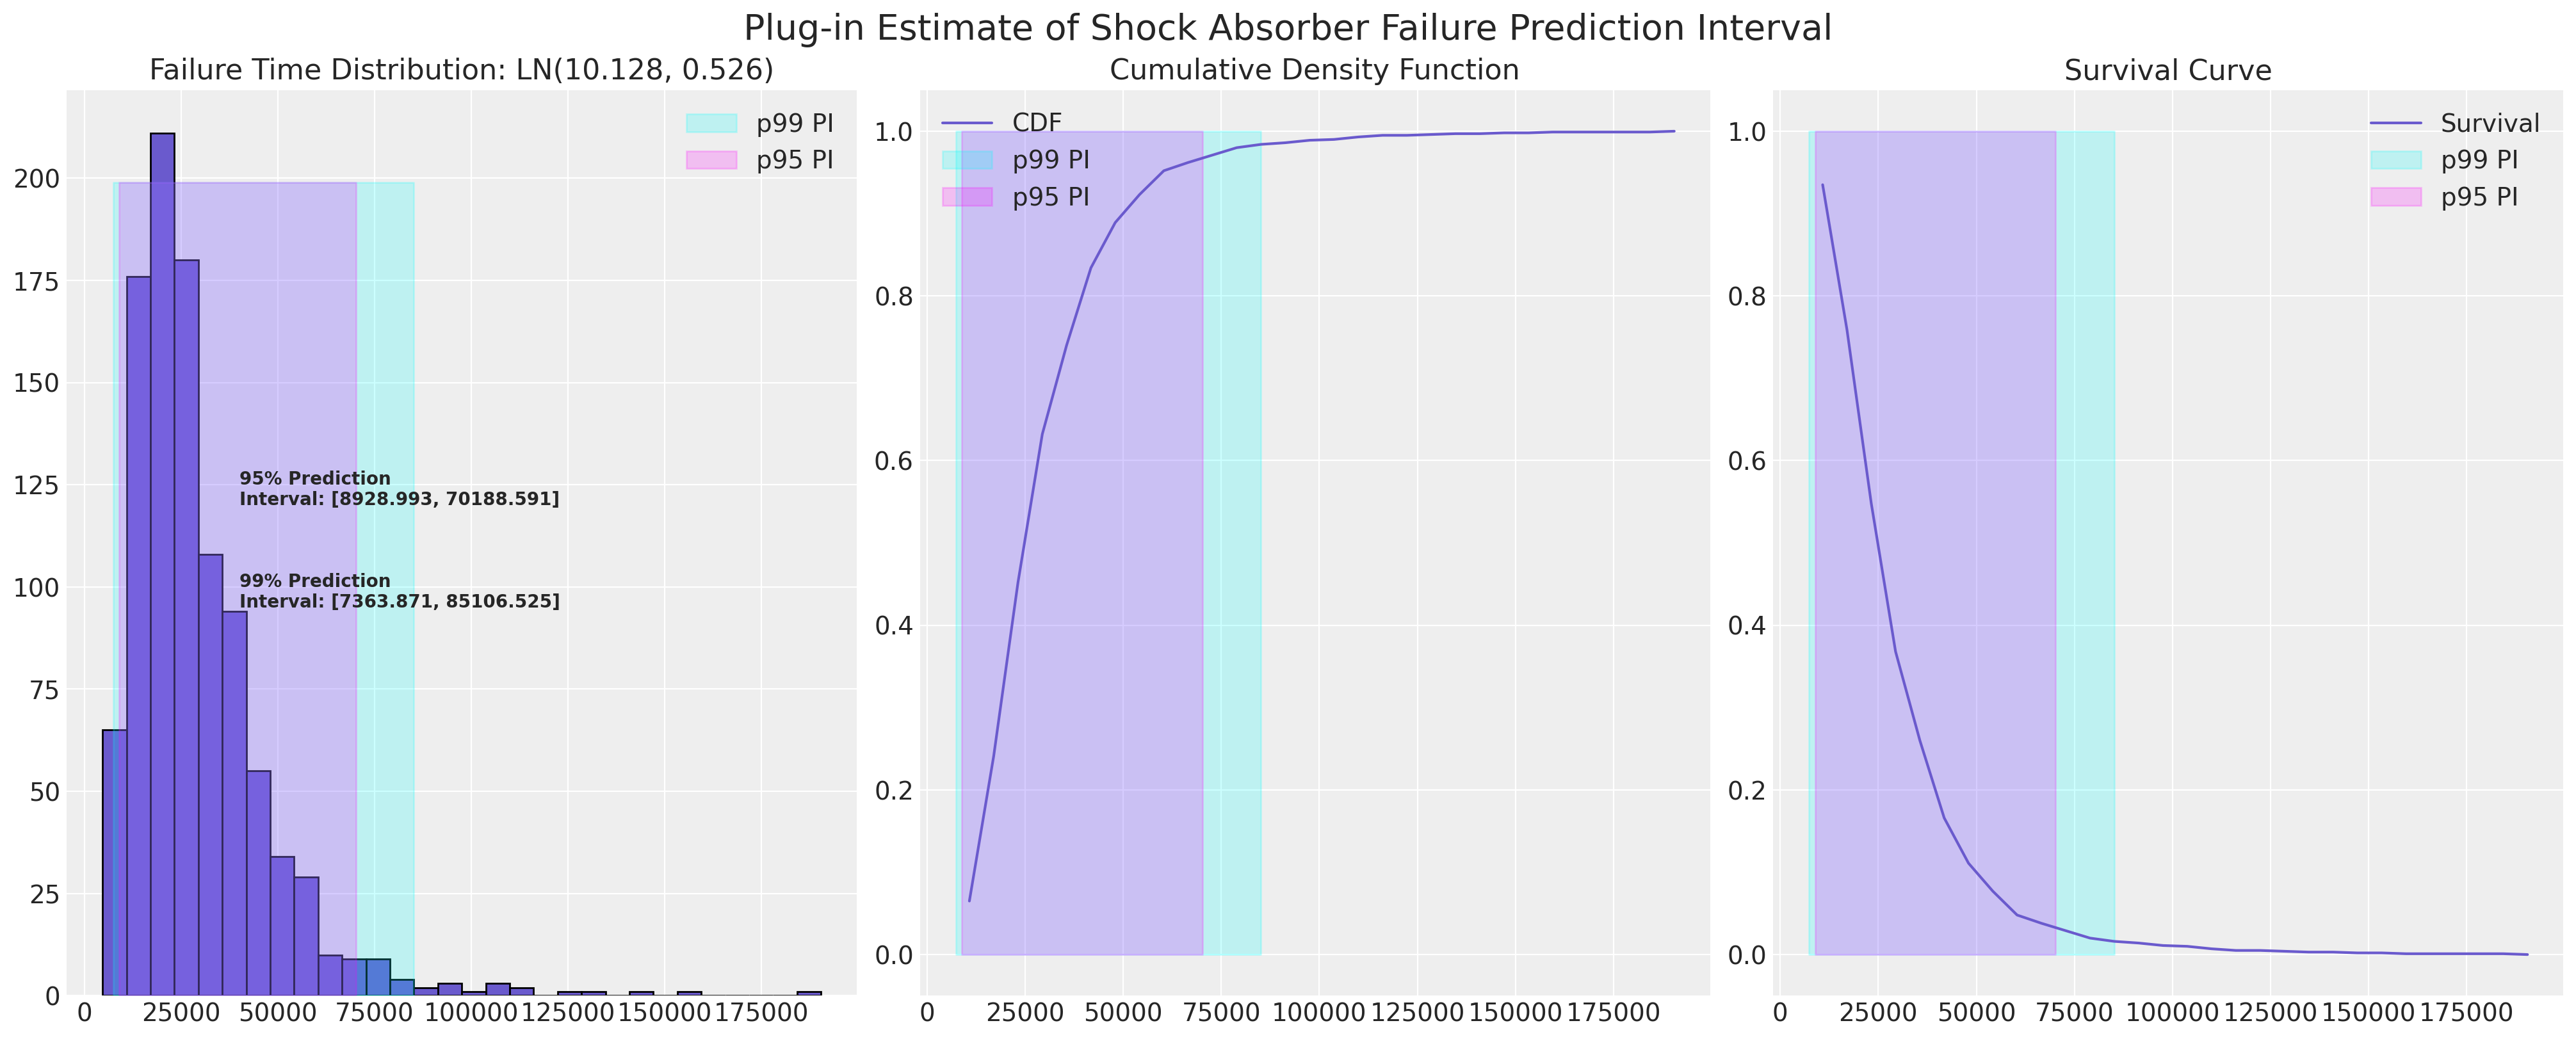

In [10]:
plot_ln_pi(
    10.128,
    0.526,
    xy=(40000, 120),
    title="Plug-in Estimate of Shock Absorber Failure Prediction Interval",
)

### Bootstrap Calibration and Coverage Estimation

We want now to estimate the coverage implied by this prediction interval, and to do so we will bootstrap estimates for the lower and upper bounds of the 95% confidence interval and ultimately assess their coverage conditional on the MLE fit. We will use the fractional weighted (bayesian) bootstrap. We'll report two methods of estimating the coverage statistic - the first is the empirical coverage based on sampling a random value from within the known range and assess if it falls between the 95% MLE lower bound and upper bounds. 

The second method we'll use to assess coverage is to bootstrap estimates of a 95% lower bound and upper bound and then assess how much those bootstrapped values would cover conditional on the MLE fit.

In [11]:
def bayes_boot(df, lb, ub, seed=100):
    w = np.random.dirichlet(np.ones(len(df)), 1)[0]
    lnf = LogNormalFitter().fit(df["t"] + 1e-25, df["failed"], weights=w)
    rv = lognorm(s=lnf.sigma_, scale=np.exp(lnf.mu_))
    ## Sample random choice from implied bootstrapped distribution
    choices = rv.rvs(1000)
    future = random.choice(choices)
    ## Check if choice is contained within the MLE 95% PI
    contained = (future >= lb) & (future <= ub)
    ## Record 95% interval of bootstrapped dist
    lb = rv.ppf(0.025)
    ub = rv.ppf(0.975)
    return lb, ub, contained, future, lnf.sigma_, lnf.mu_

In [12]:
def bootstrap(df, lb, ub, seed=100):
    draws = df[["t", "failed"]].sample(replace=True, frac=1, random_state=seed)
    draws.sort_values("t", inplace=True)
    ## Fit Lognormal Dist to
    lnf = LogNormalFitter().fit(draws["t"] + 1e-25, draws["failed"])
    rv = lognorm(s=lnf.sigma_, scale=np.exp(lnf.mu_))
    ## Sample random choice from implied distribution
    choices = rv.rvs(1000)
    future = random.choice(choices)
    ## Check if choice is contained within the MLE 95% PI
    contained = (future >= lb) & (future <= ub)
    ## Record 95% interval of bootstrapped dist
    lb = rv.ppf(0.025)
    ub = rv.ppf(0.975)
    return lb, ub, contained, future, lnf.sigma_, lnf.mu_


CIs = [bayes_boot(actuarial_table_shock, 8928, 70188, seed=i) for i in range(1000)]
draws = pd.DataFrame(
    CIs, columns=["Lower Bound PI", "Upper Bound PI", "Contained", "future", "Sigma", "Mu"]
)
draws

Lower Bound PI  Upper Bound PI  Contained        future     Sigma  \
0       6373.783884    70717.416020       True  19331.416502  0.613914   
1      10849.079864    69468.262538       True  24703.849424  0.473680   
2       9286.066437    82071.163286       True  39447.346787  0.555896   
3      10120.939866    75063.816890       True  29365.172038  0.511166   
4      10279.717912    83115.698330       True  52185.741575  0.533189   
..              ...             ...        ...           ...       ...   
995    10295.070756    46003.916671       True  12217.618548  0.381910   
996     8571.686036    87563.355272       True  49016.544485  0.592842   
997     8398.052935    53468.249766      False  83863.760976  0.472225   
998    10902.679935    56656.535068       True  26066.180383  0.420416   
999     9384.832000    92114.354711       True  44295.014262  0.582647   

            Mu  
0     9.963198  
1    10.220230  
2    10.225806  
3    10.224228  
4    10.282958  
..         ...  
995   9.987951  
996  10.218169  
997   9.961299  
998  10.120763  
999  10.288818  

[1000 rows x 6 columns]

We can use these bootstrapped statistics to further calculate quantities of the predictive distribution. In our case we could use the parametric CDF for our simple parametric model, but we'll adopt the empirical cdf here to show how this technique can be used when we have more complicated models too. 

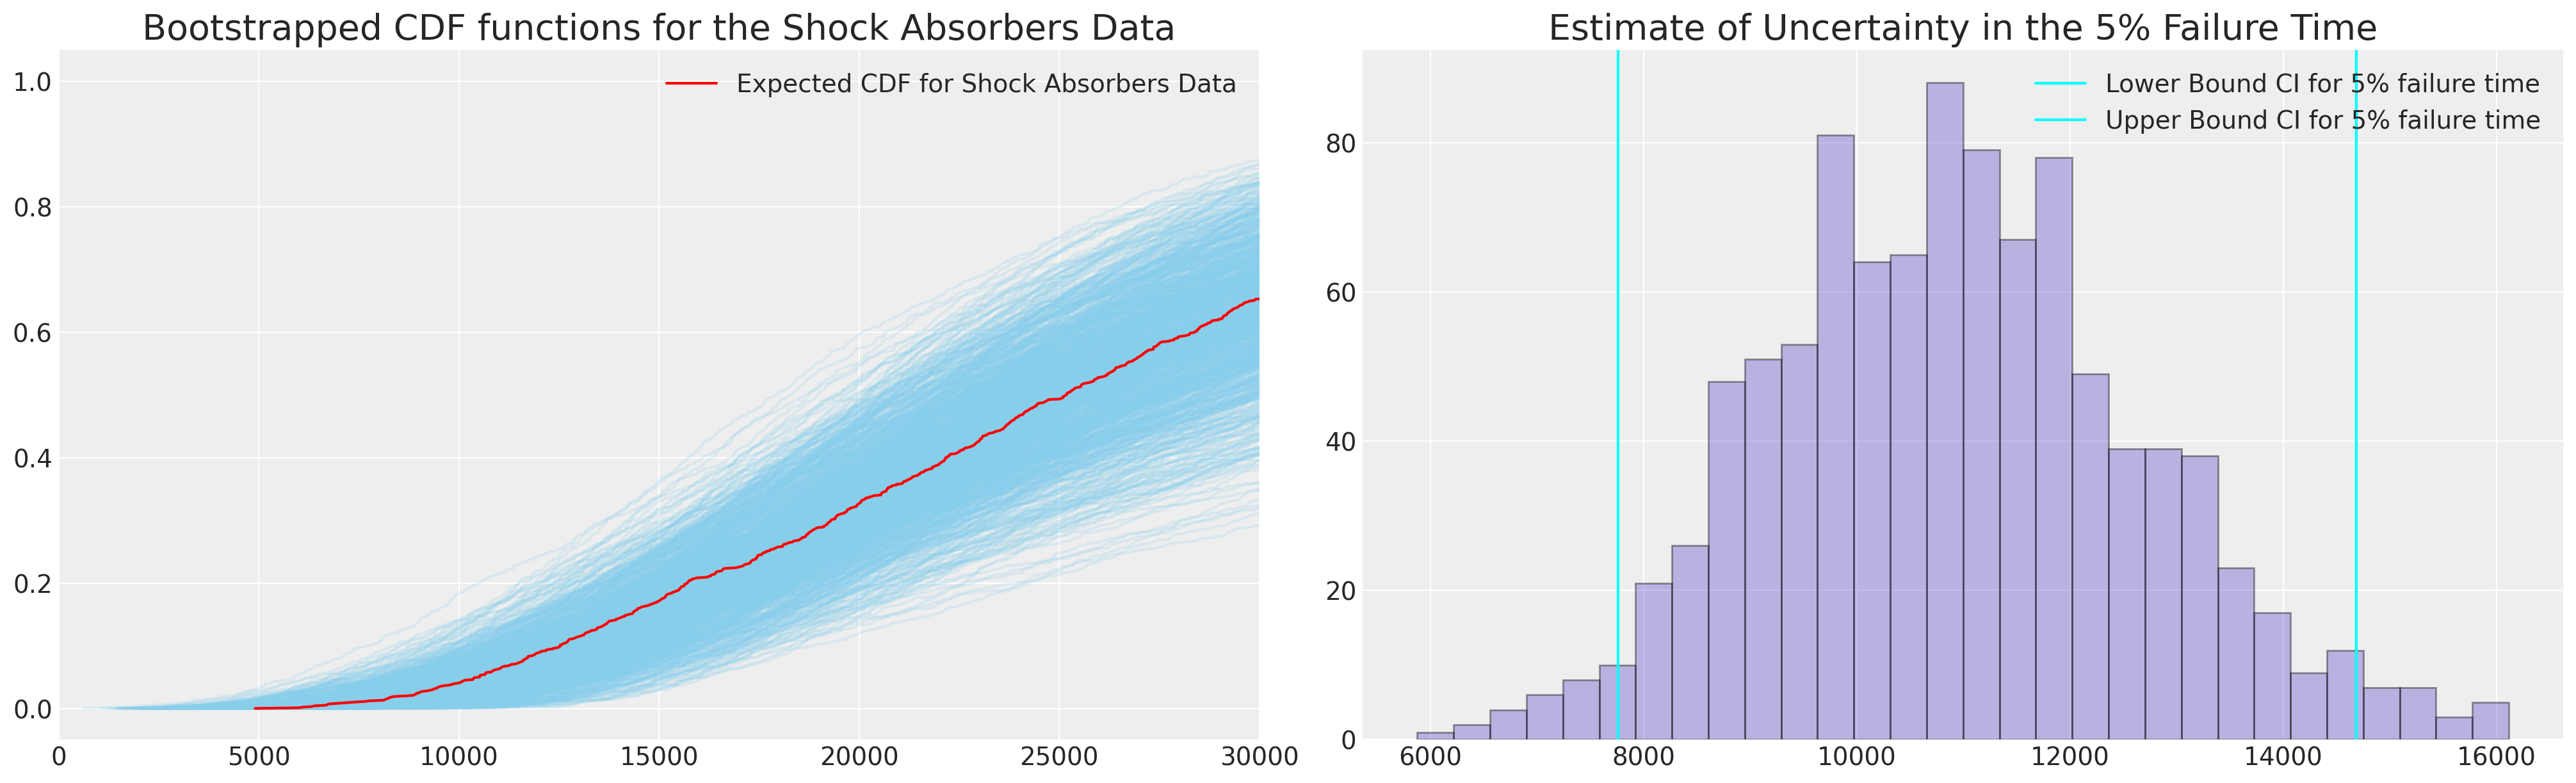

In [13]:
def ecdf(sample):

    # convert sample to a numpy array, if it isn't already
    sample = np.atleast_1d(sample)

    # find the unique values and their corresponding counts
    quantiles, counts = np.unique(sample, return_counts=True)

    # take the cumulative sum of the counts and divide by the sample size to
    # get the cumulative probabilities between 0 and 1
    cumprob = np.cumsum(counts).astype(np.double) / sample.size

    return quantiles, cumprob


fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs = axs.flatten()
ax = axs[0]
ax1 = axs[1]
hist_data = []
for i in range(1000):
    samples = lognorm(s=draws.iloc[i]["Sigma"], scale=np.exp(draws.iloc[i]["Mu"])).rvs(1000)
    qe, pe = ecdf(samples)
    ax.plot(qe, pe, color="skyblue", alpha=0.2)
    lkup = dict(zip(pe, qe))
    hist_data.append([lkup[0.05]])
hist_data = pd.DataFrame(hist_data, columns=["p05"])
samples = lognorm(s=draws["Sigma"].mean(), scale=np.exp(draws["Mu"].mean())).rvs(1000)
qe, pe = ecdf(samples)
ax.plot(qe, pe, color="red", label="Expected CDF for Shock Absorbers Data")
ax.set_xlim(0, 30_000)
ax.set_title("Bootstrapped CDF functions for the Shock Absorbers Data", fontsize=20)
ax1.hist(hist_data["p05"], color="slateblue", ec="black", alpha=0.4, bins=30)
ax1.set_title("Estimate of Uncertainty in the 5% Failure Time", fontsize=20)
ax1.axvline(
    hist_data["p05"].quantile(0.025), color="cyan", label="Lower Bound CI for 5% failure time"
)
ax1.axvline(
    hist_data["p05"].quantile(0.975), color="cyan", label="Upper Bound CI for 5% failure time"
)
ax1.legend()
ax.legend();

Next we'll plot the bootstrapped data and the two estimates of coverage we achieve conditional on the MLE fit. In other words when we want to assess the coverage of a prediction interval based on our MLE fit we can also bootstrap an estimate for this quantity.

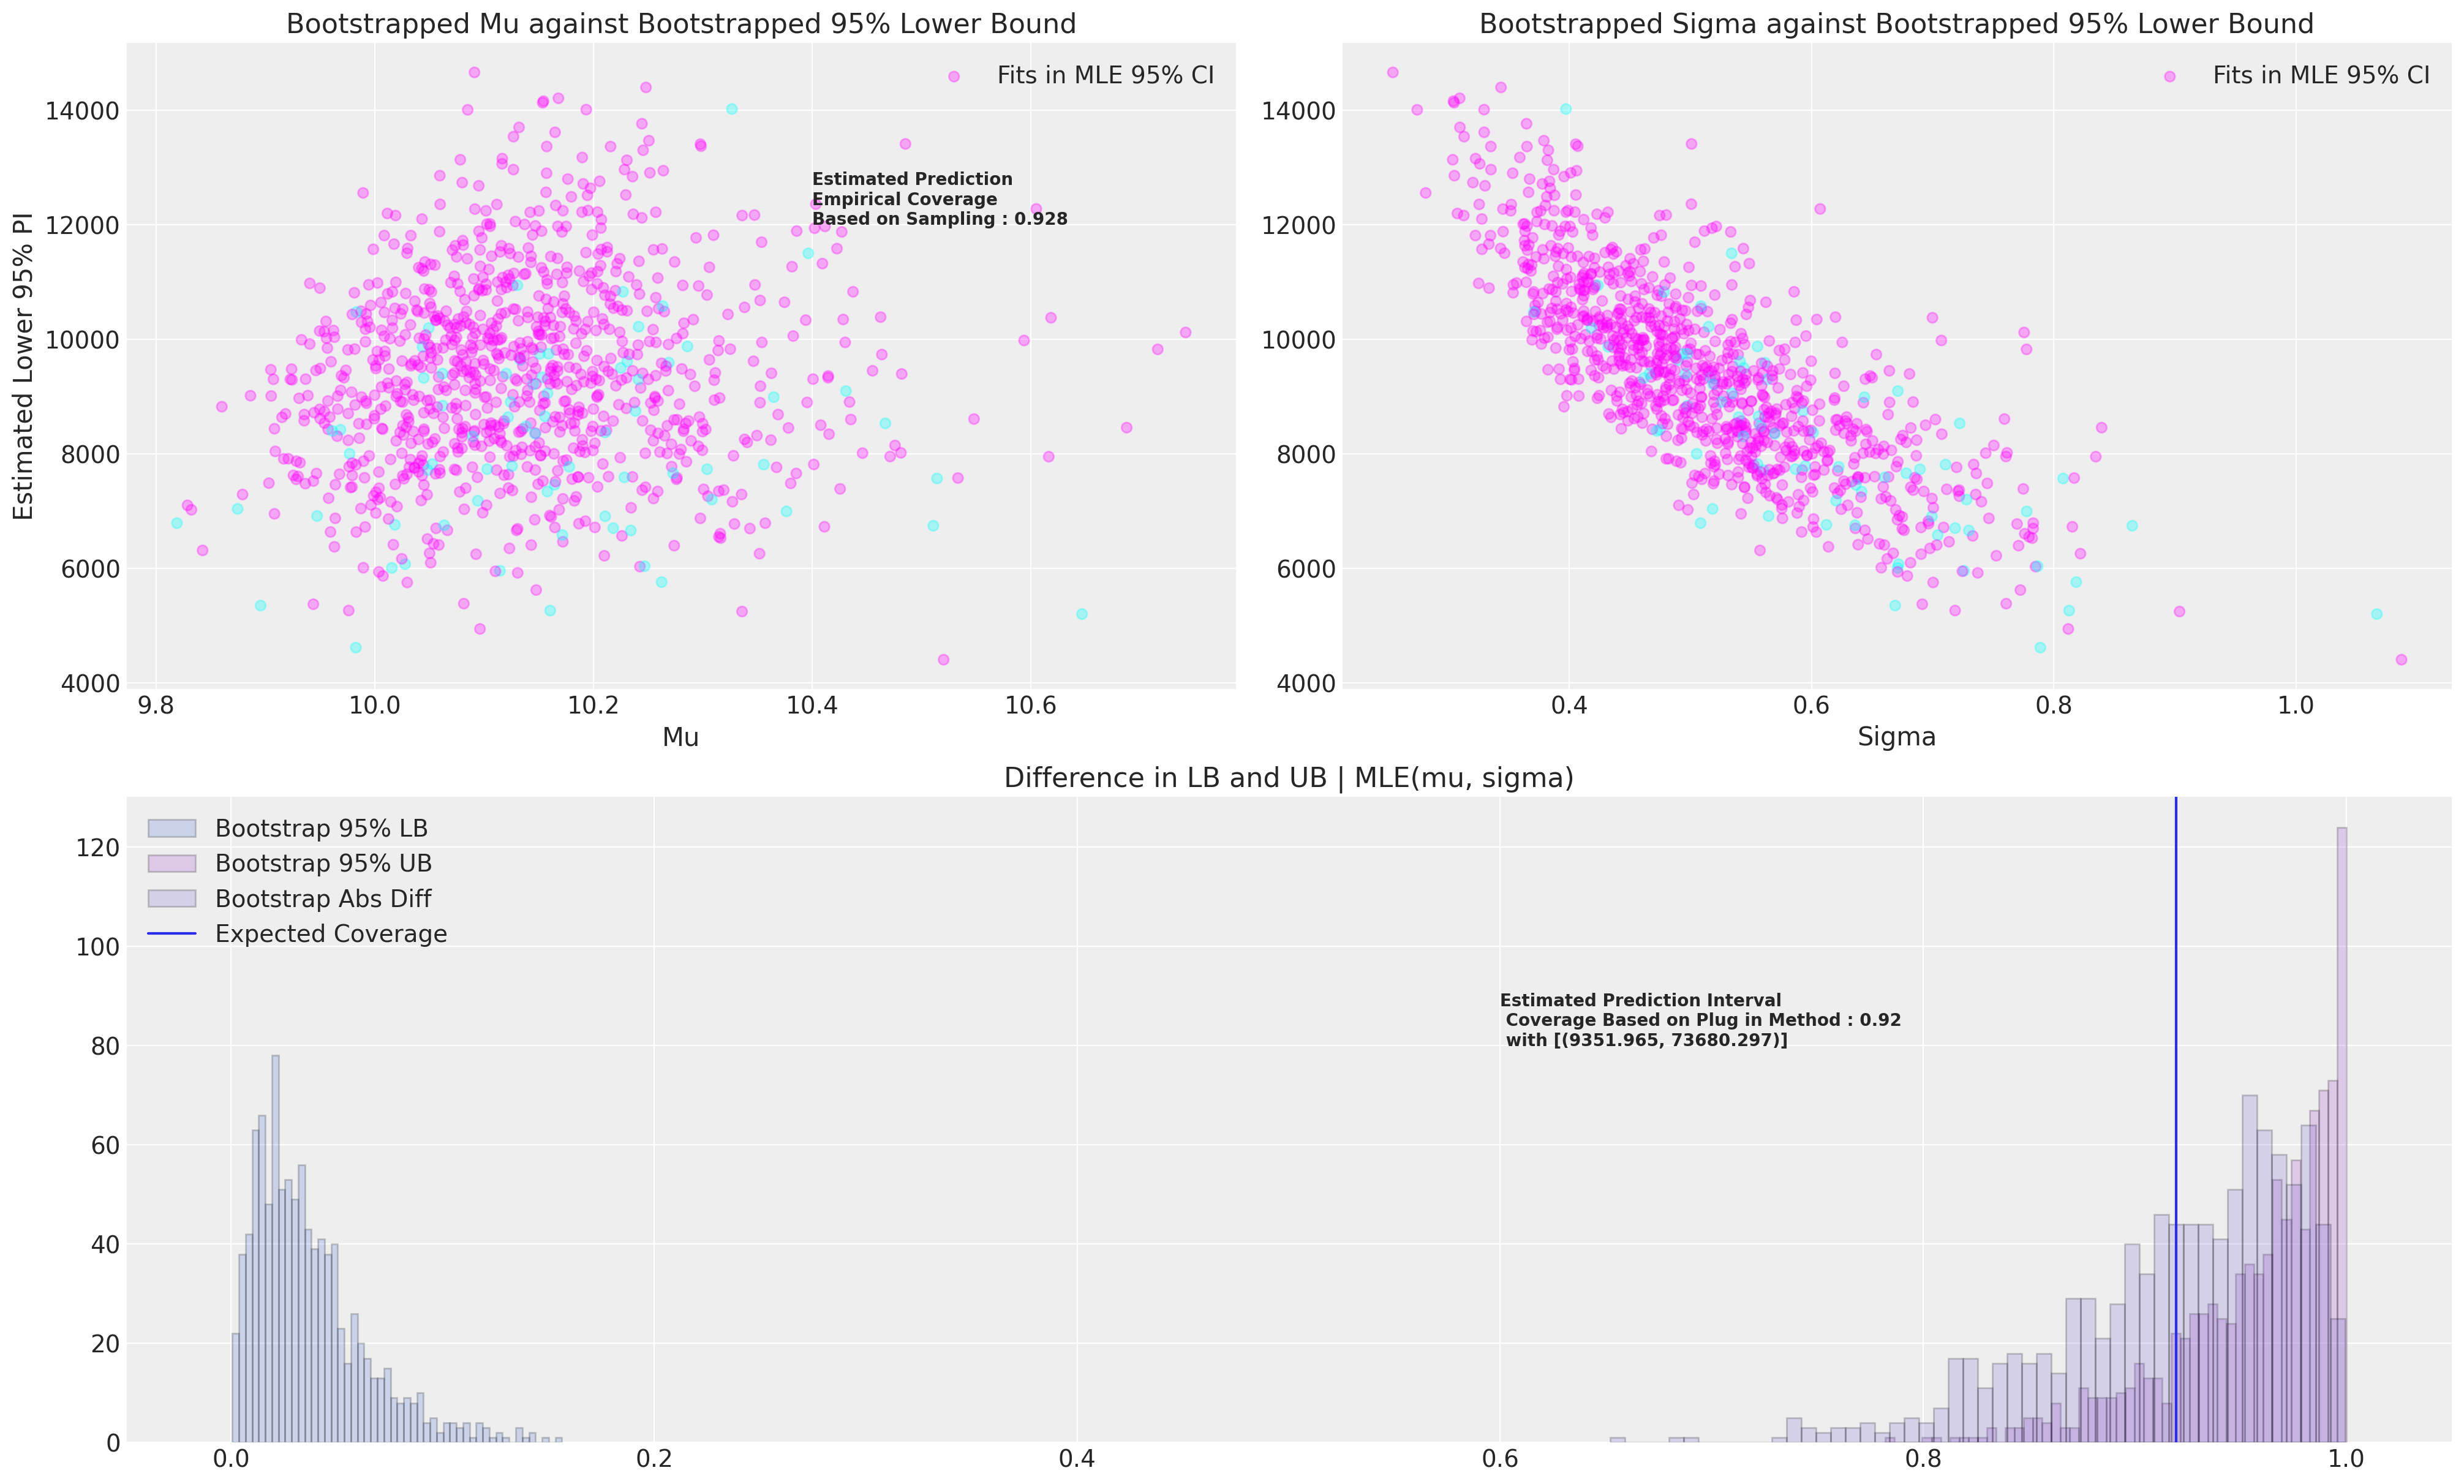

In [14]:
mosaic = """AABB
            CCCC"""
fig, axs = plt.subplot_mosaic(mosaic=mosaic, figsize=(20, 12))
mle_rv = lognorm(s=0.53, scale=np.exp(10.128))
axs = [axs[k] for k in axs.keys()]
axs[0].scatter(
    draws["Mu"],
    draws["Lower Bound PI"],
    c=draws["Contained"],
    cmap=cm.cool,
    alpha=0.3,
    label="Fits in MLE 95% CI",
)
axs[1].scatter(
    draws["Sigma"],
    draws["Lower Bound PI"],
    c=draws["Contained"],
    cmap=cm.cool,
    alpha=0.3,
    label="Fits in MLE 95% CI",
)
axs[0].set_title("Bootstrapped Mu against Bootstrapped 95% Lower Bound")
prop = draws["Contained"].sum() / len(draws)
axs[0].annotate(
    f"Estimated Prediction \nEmpirical Coverage \nBased on Sampling : {np.round(prop, 3)}",
    xy=(10.4, 12000),
    fontweight="bold",
)
axs[1].set_title("Bootstrapped Sigma against Bootstrapped 95% Lower Bound")
axs[0].legend()
axs[0].set_xlabel("Mu")
axs[1].set_xlabel("Sigma")
axs[0].set_ylabel("Estimated Lower 95% PI")
axs[1].legend()
axs[2].hist(
    mle_rv.cdf(draws["Lower Bound PI"]),
    bins=50,
    label="Bootstrap 95% LB",
    ec="k",
    color="royalblue",
    alpha=0.2,
)
axs[2].hist(
    mle_rv.cdf(draws["Upper Bound PI"]),
    bins=50,
    label="Bootstrap 95% UB",
    ec="k",
    color="darkorchid",
    alpha=0.2,
)
axs[2].hist(
    np.abs(mle_rv.cdf(draws["Lower Bound PI"]) - mle_rv.cdf(draws["Upper Bound PI"])),
    alpha=0.2,
    bins=50,
    color="slateblue",
    ec="black",
    label="Bootstrap Abs Diff",
)
axs[2].axvline(
    np.abs(mle_rv.cdf(draws["Lower Bound PI"]) - mle_rv.cdf(draws["Upper Bound PI"])).mean(),
    label="Expected Coverage",
)
axs[2].set_title("Difference in LB and UB | MLE(mu, sigma)")
axs[2].legend()

plug_in = np.abs(
    np.mean(mle_rv.cdf(draws["Lower Bound PI"])) - np.mean(mle_rv.cdf(draws["Upper Bound PI"]))
)
lb = np.round(draws["Lower Bound PI"].mean(), 3)
ub = np.round(draws["Upper Bound PI"].mean(), 3)
axs[2].annotate(
    f"Estimated Prediction Interval \n Coverage Based on Plug in Method : {np.round(plug_in, 3)} \n with [{lb, ub}]",
    xy=(0.6, 80),
    fontweight="bold",
);

These simulations should be repeated a far larger number of times than we do here. It should be clear to see how we can also vary the MLE interval size to achieve the desired coverage level.

### Bearing Cage Data: A Study in Bayesian Reliability Analysis

Next we'll look at a data set which has a slightly less clean parametric fit. The most obvious feature of this data is the small amount of failing records. The data is recorded in the **period** format with counts showing the extent of the `risk set` in each period. 

We want to spend some time with this example to show how the *frequentist* techniques which worked well to estimate the shock-absorbers data can be augmented in the case of the Bearing cage data. In particular we'll show how the issues arising can be resolved with a *Bayesian* approach.

In [15]:
bearing_cage_df = pd.read_csv(
    StringIO(
        """Hours,Censoring Indicator,Count
50,Censored,288
150,Censored,148
230,Failed,1
250,Censored,124
334,Failed,1
350,Censored,111
423,Failed,1
450,Censored,106
550,Censored,99
650,Censored,110
750,Censored,114
850,Censored,119
950,Censored,127
990,Failed,1
1009,Failed,1
1050,Censored,123
1150,Censored,93
1250,Censored,47
1350,Censored,41
1450,Censored,27
1510,Failed,1
1550,Censored,11
1650,Censored,6
1850,Censored,1
2050,Censored,2"""
    )
)


bearing_cage_df["t"] = bearing_cage_df["Hours"]
bearing_cage_df["failed"] = np.where(bearing_cage_df["Censoring Indicator"] == "Failed", 1, 0)
bearing_cage_df["censored"] = np.where(
    bearing_cage_df["Censoring Indicator"] == "Censored", bearing_cage_df["Count"], 0
)
bearing_cage_events = survival_table_from_events(
    bearing_cage_df["t"], bearing_cage_df["failed"], weights=bearing_cage_df["Count"]
).reset_index()
bearing_cage_events.rename(
    {"event_at": "t", "observed": "failed", "at_risk": "risk_set"}, axis=1, inplace=True
)
actuarial_table_bearings = make_actuarial_table(bearing_cage_events)
pd.options.display.float_format = "{:.5f}".format
actuarial_table_bearings

t  removed  failed  censored  entrance  risk_set   p_hat  1-p_hat  \
0     0.00000        0       0         0      1703      1703 0.00000  1.00000   
1    50.00000      288       0       288         0      1703 0.00000  1.00000   
2   150.00000      148       0       148         0      1415 0.00000  1.00000   
3   230.00000        1       1         0         0      1267 0.00079  0.99921   
4   250.00000      124       0       124         0      1266 0.00000  1.00000   
5   334.00000        1       1         0         0      1142 0.00088  0.99912   
6   350.00000      111       0       111         0      1141 0.00000  1.00000   
7   423.00000        1       1         0         0      1030 0.00097  0.99903   
8   450.00000      106       0       106         0      1029 0.00000  1.00000   
9   550.00000       99       0        99         0       923 0.00000  1.00000   
10  650.00000      110       0       110         0       824 0.00000  1.00000   
11  750.00000      114       0       114         0       714 0.00000  1.00000   
12  850.00000      119       0       119         0       600 0.00000  1.00000   
13  950.00000      127       0       127         0       481 0.00000  1.00000   
14  990.00000        1       1         0         0       354 0.00282  0.99718   
15 1009.00000        1       1         0         0       353 0.00283  0.99717   
16 1050.00000      123       0       123         0       352 0.00000  1.00000   
17 1150.00000       93       0        93         0       229 0.00000  1.00000   
18 1250.00000       47       0        47         0       136 0.00000  1.00000   
19 1350.00000       41       0        41         0        89 0.00000  1.00000   
20 1450.00000       27       0        27         0        48 0.00000  1.00000   
21 1510.00000        1       1         0         0        21 0.04762  0.95238   
22 1550.00000       11       0        11         0        20 0.00000  1.00000   
23 1650.00000        6       0         6         0         9 0.00000  1.00000   
24 1850.00000        1       0         1         0         3 0.00000  1.00000   
25 2050.00000        2       0         2         0         2 0.00000  1.00000   

     S_hat   CH_hat   F_hat   V_hat  Standard_Error  CI_95_lb  CI_95_ub  \
0  1.00000 -0.00000 0.00000 0.00000         0.00000   0.00000   0.00000   
1  1.00000 -0.00000 0.00000 0.00000         0.00000   0.00000   0.00000   
2  1.00000 -0.00000 0.00000 0.00000         0.00000   0.00000   0.00000   
3  0.99921  0.00079 0.00079 0.00000         0.00079   0.00000   0.00234   
4  0.99921  0.00079 0.00079 0.00000         0.00079   0.00000   0.00234   
5  0.99834  0.00167 0.00166 0.00000         0.00118   0.00000   0.00397   
6  0.99834  0.00167 0.00166 0.00000         0.00118   0.00000   0.00397   
7  0.99737  0.00264 0.00263 0.00000         0.00152   0.00000   0.00562   
8  0.99737  0.00264 0.00263 0.00000         0.00152   0.00000   0.00562   
9  0.99737  0.00264 0.00263 0.00000         0.00152   0.00000   0.00562   
10 0.99737  0.00264 0.00263 0.00000         0.00152   0.00000   0.00562   
11 0.99737  0.00264 0.00263 0.00000         0.00152   0.00000   0.00562   
12 0.99737  0.00264 0.00263 0.00000         0.00152   0.00000   0.00562   
13 0.99737  0.00264 0.00263 0.00000         0.00152   0.00000   0.00562   
14 0.99455  0.00547 0.00545 0.00001         0.00320   0.00000   0.01172   
15 0.99173  0.00830 0.00827 0.00002         0.00425   0.00000   0.01660   
16 0.99173  0.00830 0.00827 0.00002         0.00425   0.00000   0.01660   
17 0.99173  0.00830 0.00827 0.00002         0.00425   0.00000   0.01660   
18 0.99173  0.00830 0.00827 0.00002         0.00425   0.00000   0.01660   
19 0.99173  0.00830 0.00827 0.00002         0.00425   0.00000   0.01660   
20 0.99173  0.00830 0.00827 0.00002         0.00425   0.00000   0.01660   
21 0.94451  0.05709 0.05549 0.00214         0.04626   0.00000   0.14617   
22 0.94451  0.05709 0.05549 0.00214         0.04626   0.00000   0.14617   
23 0.94451  0.05709 0.05

To estimate a univariate or non-parametric CDF we need to disaggregate the **period** format data into an **item-period** format.

### Item Period Data Format

In [16]:
item_period = bearing_cage_df["Hours"].to_list() * bearing_cage_df["Count"].sum()
ids = [[i] * 25 for i in range(bearing_cage_df["Count"].sum())]
ids = [int(i) for l in ids for i in l]
item_period_bearing_cage = pd.DataFrame(item_period, columns=["t"])
item_period_bearing_cage["id"] = ids
item_period_bearing_cage["failed"] = np.zeros(len(item_period_bearing_cage))

## Censor appropriate number of ids
unique_ids = item_period_bearing_cage["id"].unique()
censored = bearing_cage_df[bearing_cage_df["Censoring Indicator"] == "Censored"]
i = 0
stack = []
for hour, count, idx in zip(censored["Hours"], censored["Count"], censored["Count"].cumsum()):
    temp = item_period_bearing_cage[
        item_period_bearing_cage["id"].isin(unique_ids[i:idx])
        & (item_period_bearing_cage["t"] == hour)
    ]
    stack.append(temp)
    i = idx

censored_clean = pd.concat(stack)

### Add  appropriate number of failings
stack = []
unique_times = censored_clean["t"].unique()
for id, fail_time in zip(
    [9999, 9998, 9997, 9996, 9995, 9994],
    bearing_cage_df[bearing_cage_df["failed"] == 1]["t"].values,
):
    temp = pd.DataFrame(unique_times[unique_times < fail_time], columns=["t"])
    temp["id"] = id
    temp["failed"] = 0
    temp = pd.concat([temp, pd.DataFrame({"t": [fail_time], "id": [id], "failed": [1]}, index=[0])])
    stack.append(temp)

failed_clean = pd.concat(stack).sort_values(["id", "t"])
censored_clean
item_period_bearing_cage = pd.concat([failed_clean, censored_clean])
## Transpose for more concise visual
item_period_bearing_cage.head(30).T

0          1          2          3          4          5  \
t        50.00000  150.00000  250.00000  350.00000  450.00000  550.00000   
id     9994.00000 9994.00000 9994.00000 9994.00000 9994.00000 9994.00000   
failed    0.00000    0.00000    0.00000    0.00000    0.00000    0.00000   

                6          7          8          9  ...          4          5  \
t       650.00000  750.00000  850.00000  950.00000  ...  450.00000  550.00000   
id     9994.00000 9994.00000 9994.00000 9994.00000  ... 9995.00000 9995.00000   
failed    0.00000    0.00000    0.00000    0.00000  ...    0.00000    0.00000   

                6          7          8          9          0          0  \
t       650.00000  750.00000  850.00000  950.00000 1009.00000   50.00000   
id     9995.00000 9995.00000 9995.00000 9995.00000 9995.00000 9996.00000   
failed    0.00000    0.00000    0.00000    0.00000    1.00000    0.00000   

                1          2  
t       150.00000  250.00000  
id     9996.00000 9996.00000  
failed    0.00000    0.00000  

[3 rows x 30 columns]

In [17]:
assert item_period_bearing_cage["id"].nunique() == 1703
assert item_period_bearing_cage["failed"].sum() == 6
assert item_period_bearing_cage[item_period_bearing_cage["t"] >= 1850]["id"].nunique() == 3

As we plot the empirical CDF we see that the y-axis only ever reaches as maximum height of 0.05. A naive MLE fit will go dramatically wrong in extrapolating outside the observed range of the data.

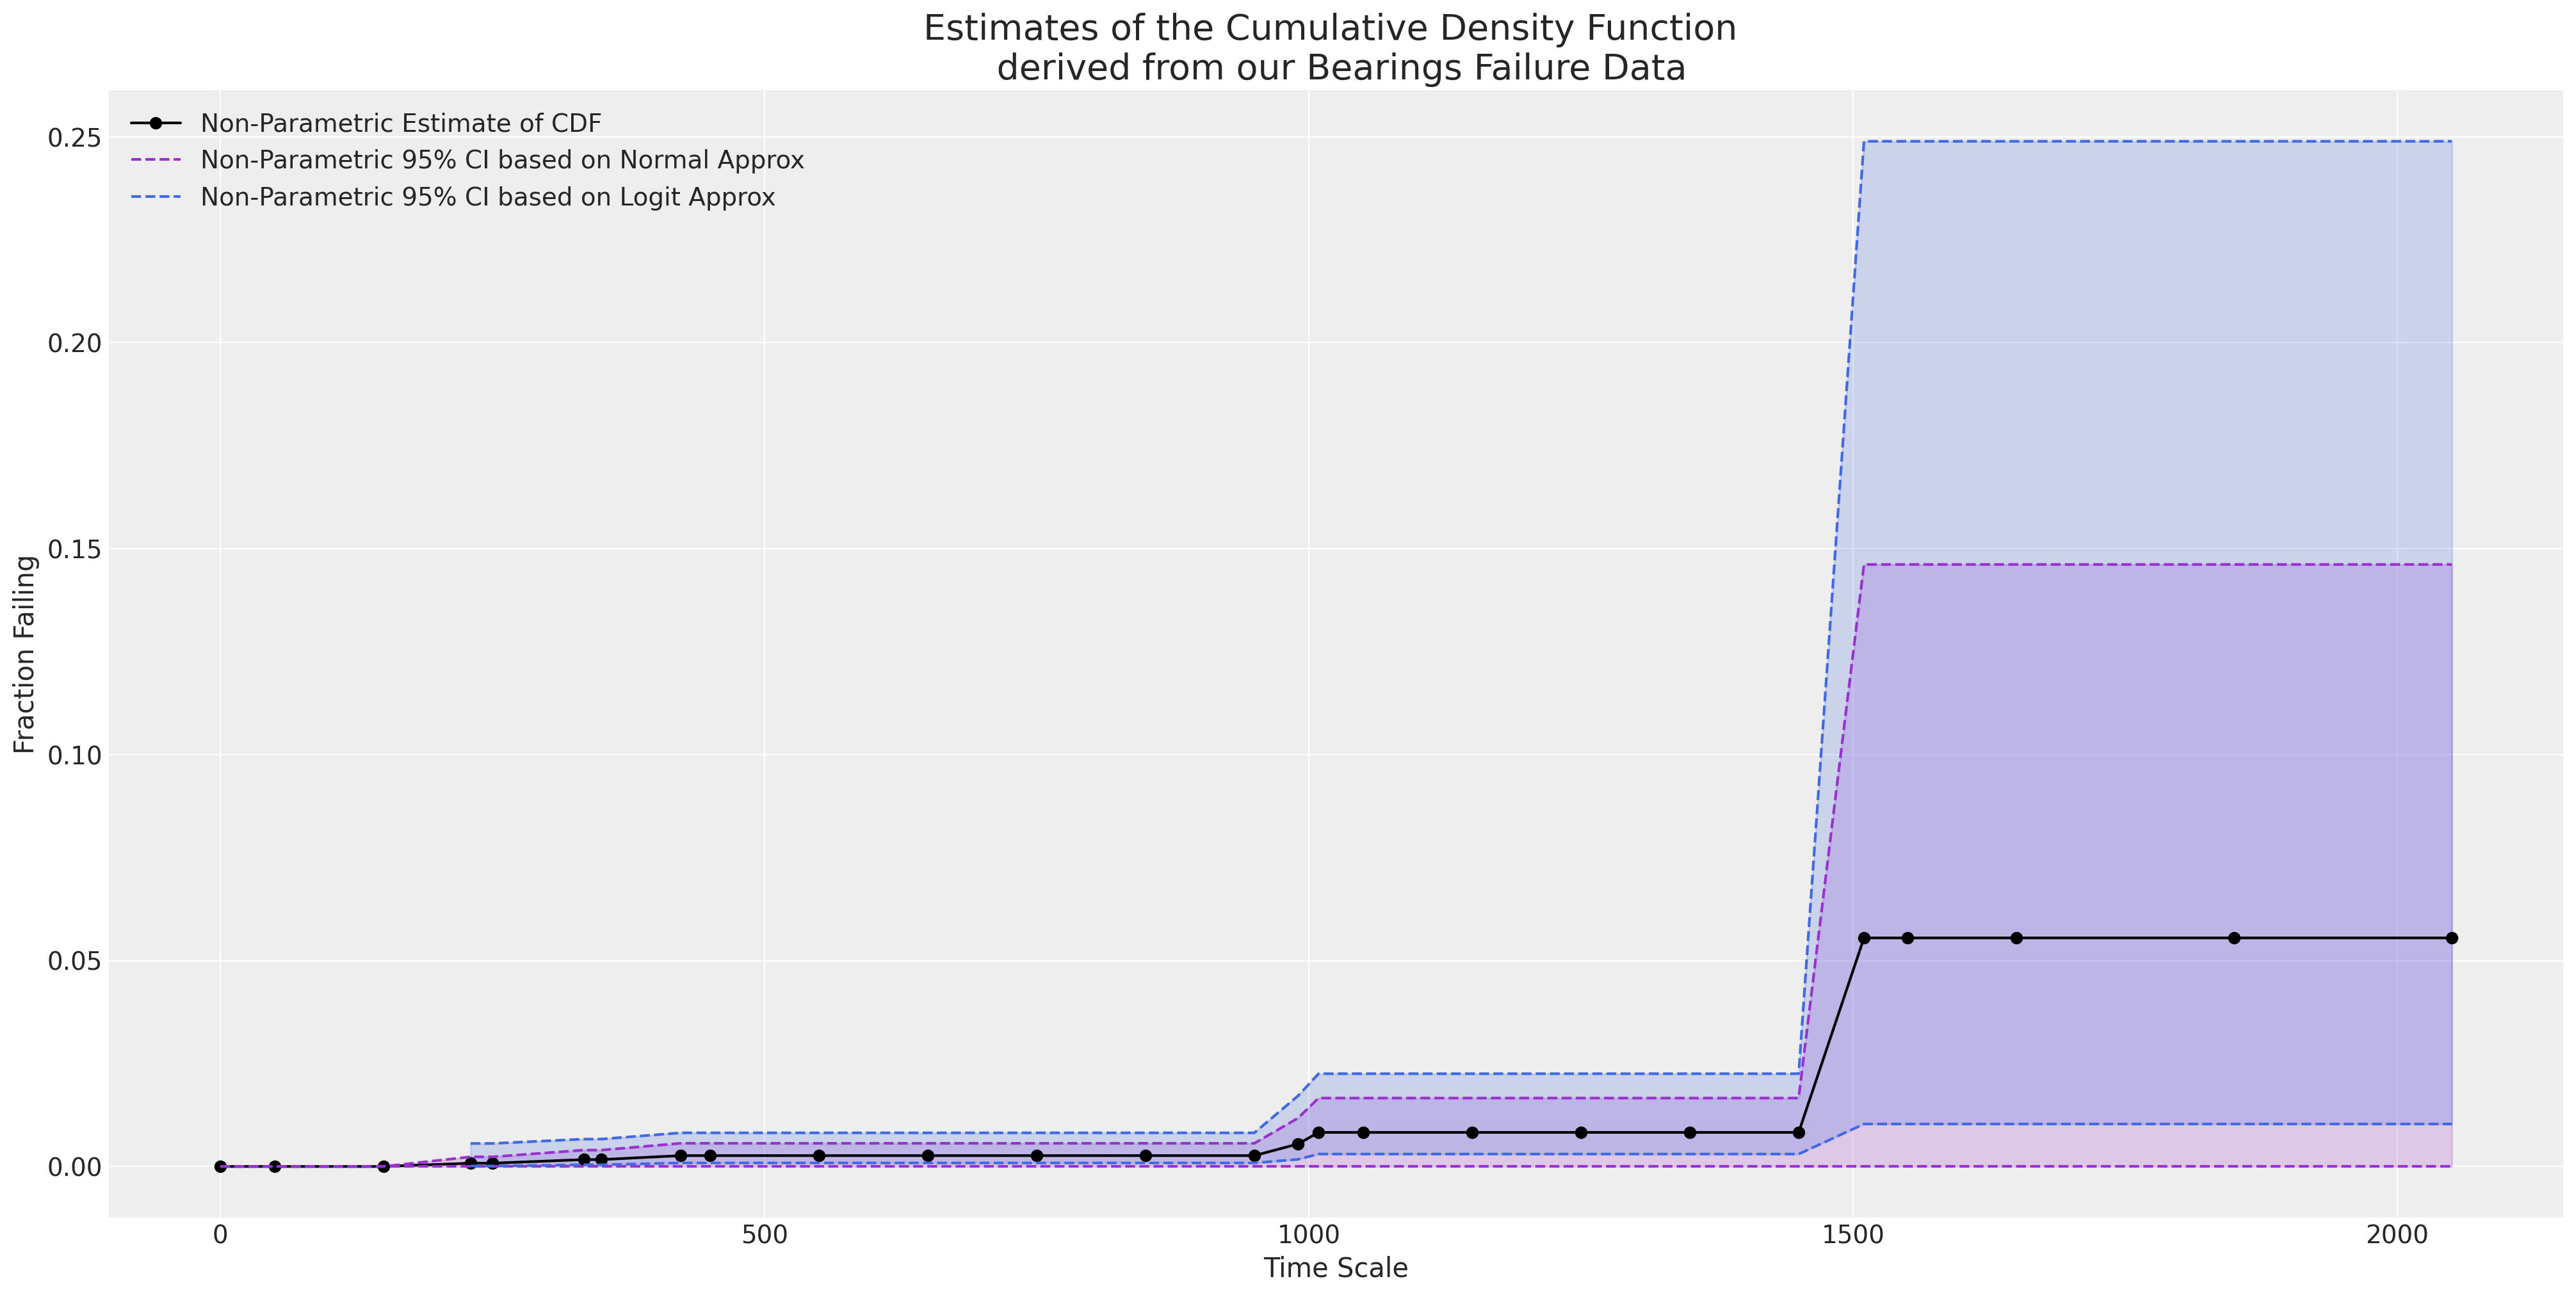

In [18]:
ax = plot_cdfs(
    actuarial_table_bearings,
    title="Bearings",
    dist_fits=False,
    xy=(20, 0.7),
    item_period=item_period_bearing_cage,
)

## Probability Plots: Comparing CDFs in a Restricted Linear Range

With this adjustment to the data format we compare the MLE fit against the empirical CDF. In the next section we'll use the technique of linearising the MLE fits so that can perform a visual "goodness of fit" check. These types of plots rely on a transformation that can be applied to the location and scale distributions to turn their CDF into a linear space.  

For both the Lognormal and Weibull fits we can represent their CDF in a linear space as a relationship between the logged value t and an appropriate $CDF^{-1}$.

/Users/nathanielforde/opt/miniconda3/envs/pymc_ar_ex/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/nathanielforde/opt/miniconda3/envs/pymc_ar_ex/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/99/gp2xl6x513s0tvl3cx79zf7m0000gn/T/ipykernel_6497/2628457585.py:2: RuntimeWarning: divide by zero encountered in log
  return np.log(-np.log(1 - p))
/Users/nathanielforde/opt/miniconda3/envs/pymc_ar_ex/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/99/gp2xl6x513s0tvl3cx79zf7m0000gn/T/ipykernel_6497/2628457585.py:2: RuntimeWarning: divide by zero encountered in log
  return np.log(-np.log(1 - p))
/var/folders/99/gp2xl6x513s0tvl3

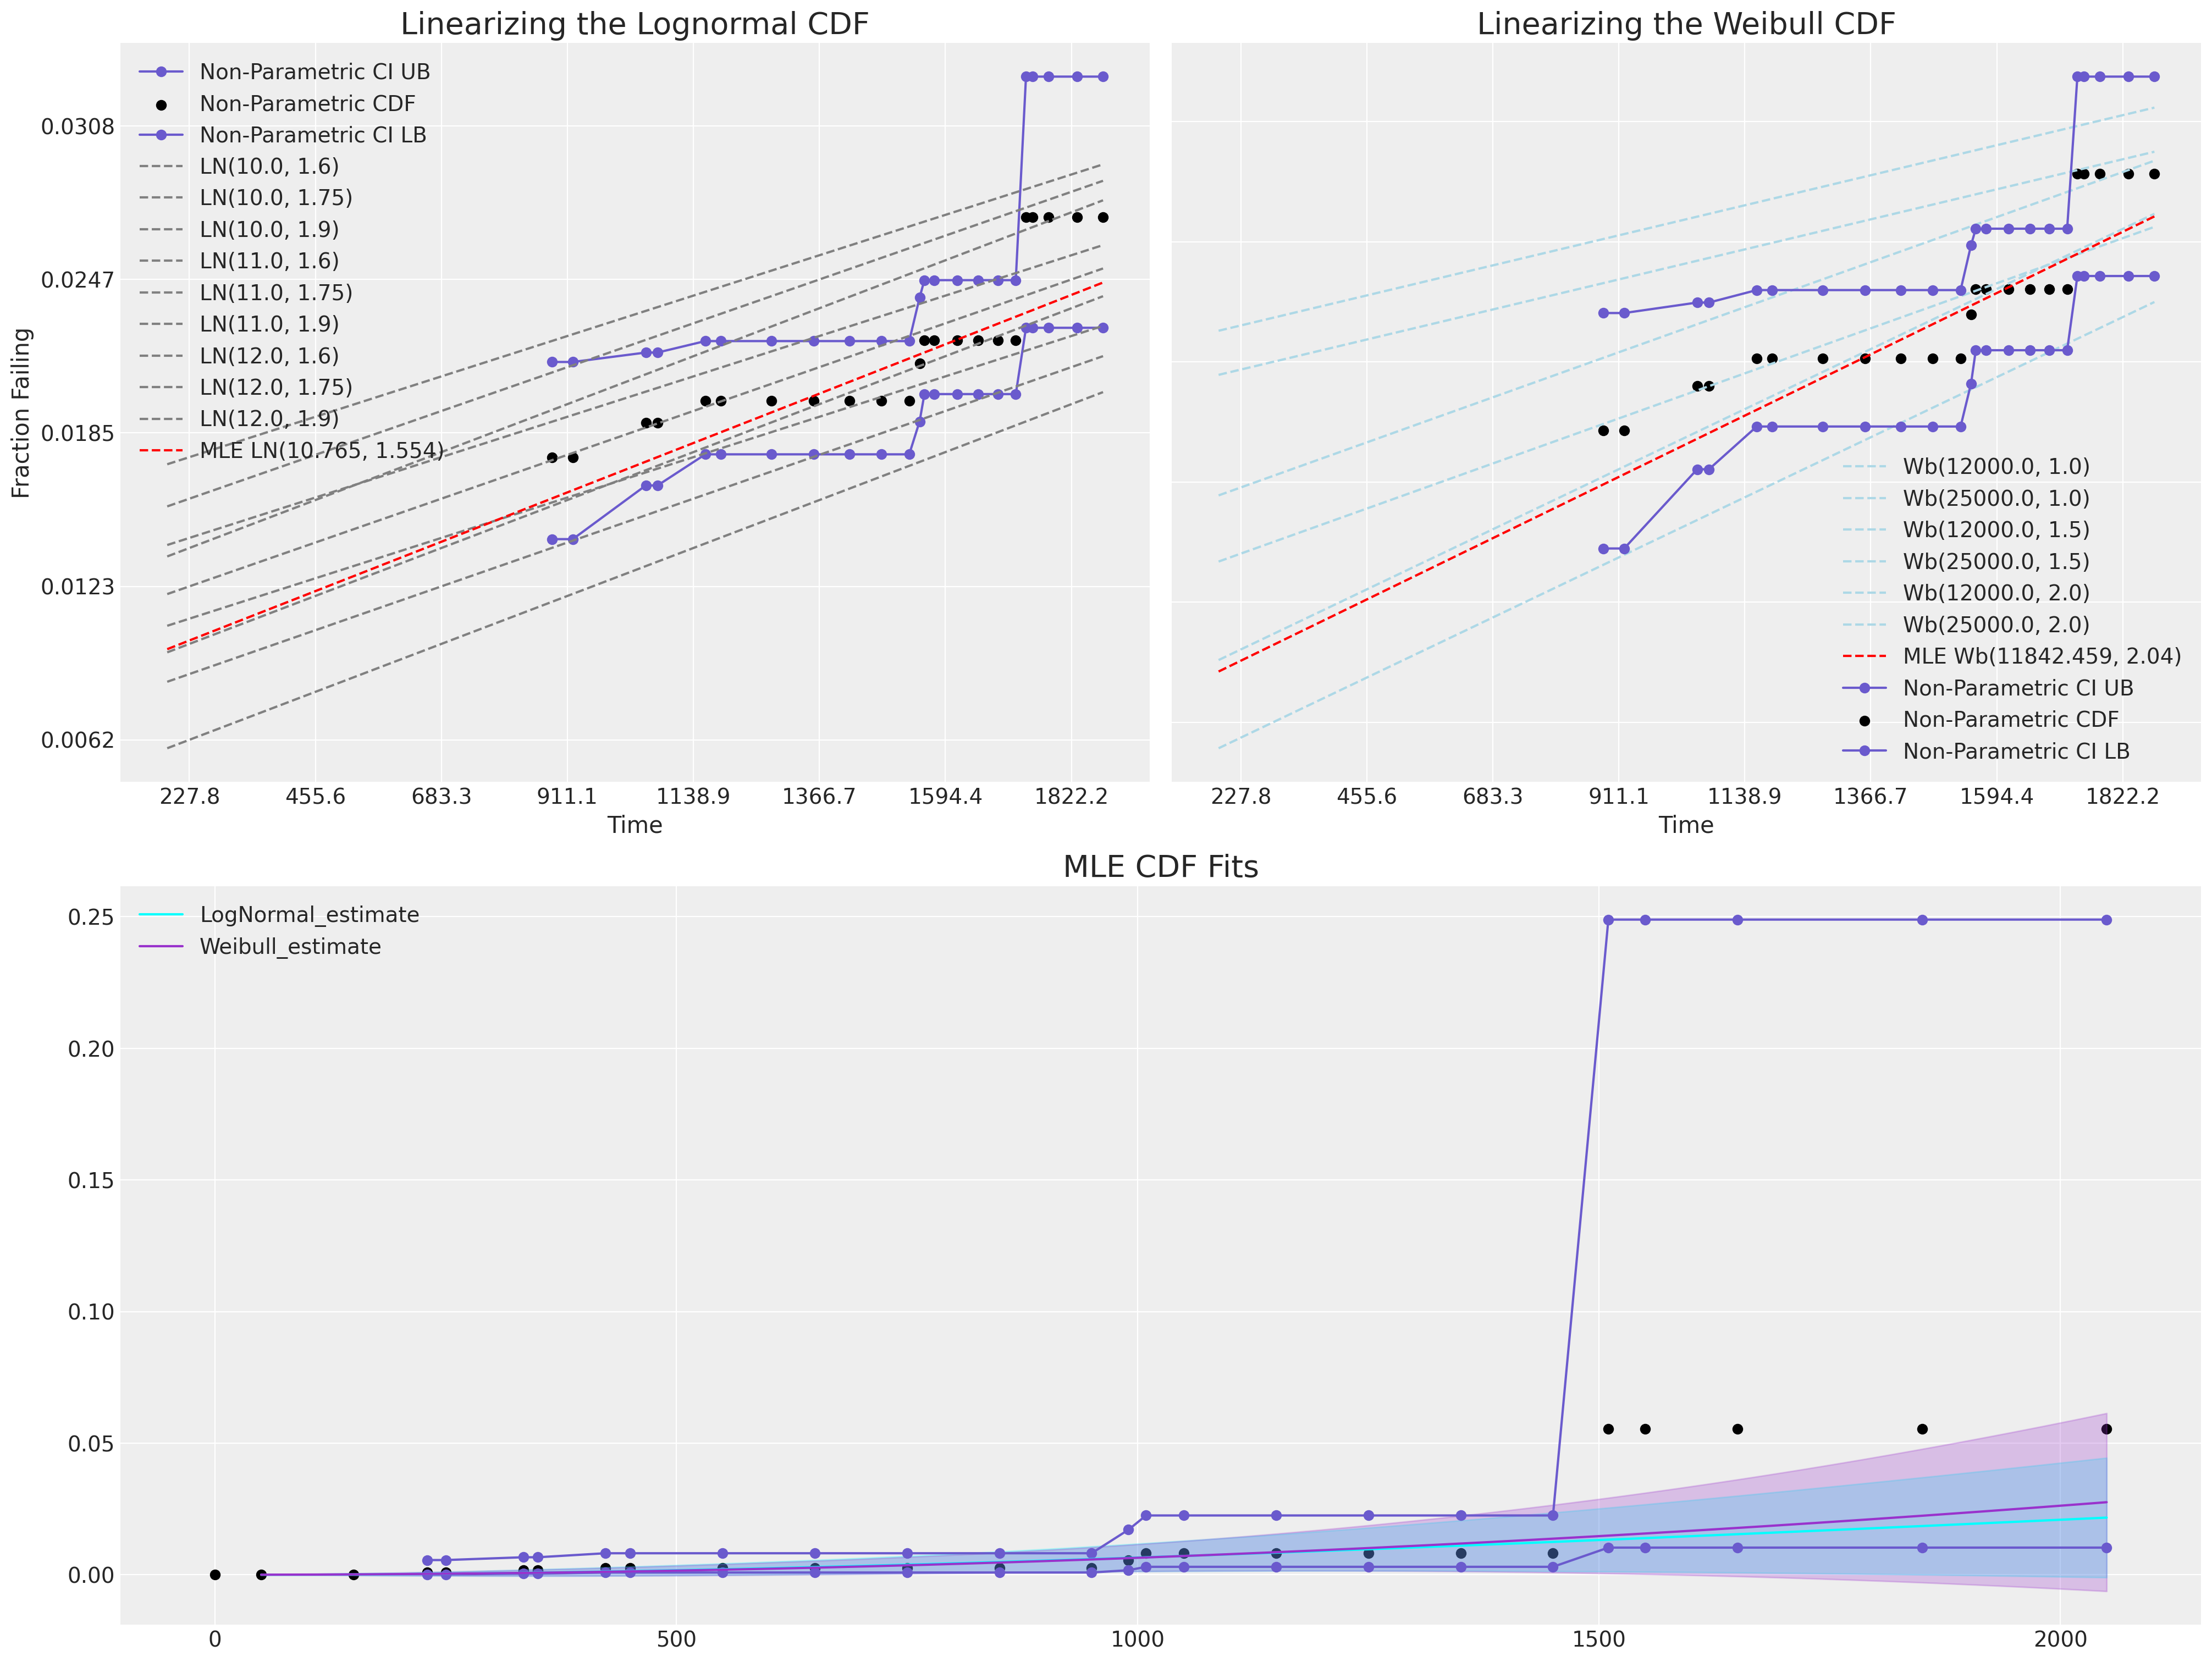

In [19]:
def sev_ppf(p):
    return np.log(-np.log(1 - p))


mosaic = """AABB
            CCCC"""
fig, axs = plt.subplot_mosaic(mosaic=mosaic, figsize=(20, 15))
axs = [axs[k] for k in axs.keys()]
ax = axs[0]
ax2 = axs[1]
ax3 = axs[2]
ax.plot(
    np.log(actuarial_table_bearings["t"]),
    norm.ppf(actuarial_table_bearings["logit_CI_95_ub"]),
    "-o",
    label="Non-Parametric CI UB",
    color="slateblue",
)
ax.scatter(
    np.log(actuarial_table_bearings["t"]),
    norm.ppf(actuarial_table_bearings["ploting_position"]),
    label="Non-Parametric CDF",
    color="black",
)
ax.plot(
    np.log(actuarial_table_bearings["t"]),
    norm.ppf(actuarial_table_bearings["logit_CI_95_lb"]),
    "-o",
    label="Non-Parametric CI LB",
    color="slateblue",
)
for mu in np.linspace(10, 12, 3):
    for sigma in np.linspace(1.6, 1.9, 3):
        rv = lognorm(s=sigma, scale=np.exp(mu))
        ax.plot(
            np.log(actuarial_table_bearings["t"]),
            norm.ppf(rv.cdf(actuarial_table_bearings["t"])),
            "--",
            label=f"LN({np.round(mu, 3)}, {np.round(sigma, 3)})",
            color="grey",
        )

lnf = LogNormalFitter().fit(item_period_bearing_cage["t"], item_period_bearing_cage["failed"])
rv = lognorm(s=lnf.sigma_, scale=np.exp(lnf.mu_))
ax.plot(
    np.log(actuarial_table_bearings["t"]),
    norm.ppf(rv.cdf(actuarial_table_bearings["t"])),
    "--",
    label=f"MLE LN({np.round(lnf.mu_, 3)}, {np.round(lnf.sigma_, 3)})",
    color="RED",
)

for r in np.linspace(1, 2, 3):
    for s in np.linspace(12000, 25000, 2):
        rv = weibull_min(c=r, scale=s)
        ax2.plot(
            np.log(actuarial_table_bearings["t"]),
            sev_ppf(rv.cdf(actuarial_table_bearings["t"])),
            "--",
            label=f"Wb({np.round(s, 3)}, {np.round(r, 3)})",
            color="lightblue",
        )


wbf = WeibullFitter().fit(item_period_bearing_cage["t"], item_period_bearing_cage["failed"])
rv = weibull_min(c=wbf.rho_, scale=wbf.lambda_)
ax2.plot(
    np.log(actuarial_table_bearings["t"]),
    sev_ppf(rv.cdf(actuarial_table_bearings["t"])),
    "--",
    label=f"MLE Wb({np.round(wbf.lambda_, 3)}, {np.round(wbf.rho_, 3)})",
    color="red",
)

ax2.plot(
    np.log(actuarial_table_bearings["t"]),
    sev_ppf(actuarial_table_bearings["logit_CI_95_ub"]),
    "-o",
    label="Non-Parametric CI UB",
    color="slateblue",
)
ax2.scatter(
    np.log(actuarial_table_bearings["t"]),
    sev_ppf(actuarial_table_bearings["ploting_position"]),
    label="Non-Parametric CDF",
    color="black",
)
ax2.plot(
    np.log(actuarial_table_bearings["t"]),
    sev_ppf(actuarial_table_bearings["logit_CI_95_lb"]),
    "-o",
    label="Non-Parametric CI LB",
    color="slateblue",
)

ax3.plot(
    actuarial_table_bearings["t"],
    actuarial_table_bearings["logit_CI_95_ub"],
    "-o",
    label="Non-Parametric CI UB",
    color="slateblue",
)
ax3.scatter(
    actuarial_table_bearings["t"],
    actuarial_table_bearings["F_hat"],
    label="Non-Parametric CDF",
    color="black",
)
ax3.plot(
    actuarial_table_bearings["t"],
    actuarial_table_bearings["logit_CI_95_lb"],
    "-o",
    label="Non-Parametric CI LB",
    color="slateblue",
)
lnf.plot_cumulative_density(ax=ax3, color="cyan")
wbf.plot_cumulative_density(ax=ax3, color="darkorchid")


ax2.set_title("Linearizing the Weibull CDF", fontsize=20)
ax.set_title("Linearizing the Lognormal CDF", fontsize=20)
ax3.set_title("MLE CDF Fits", fontsize=20)
ax.legend()
ax.set_xlabel("Time")
ax2.set_xlabel("Time")
xticks = np.round(np.linspace(0, actuarial_table_bearings["t"].max(), 10), 1)
yticks = np.round(np.linspace(0, actuarial_table_bearings["F_hat"].max(), 10), 4)
ax.set_xticklabels(xticks)
ax.set_yticklabels(yticks)
ax2.set_xticklabels(xticks)
ax2.set_yticklabels([])
ax2.legend()
ax.set_ylabel("Fraction Failing");

We can see here how neither MLE fit covers the range of observed data.

## Bayesian Modelling of Reliability Data

We've now seen how to model and visualise the parametric model fits to sparse reliability using a frequentist or MLE framework. We want to now show how the same style of inferences can be achieved in the Bayesian paradigm. 

As in the MLE paradigm we need to model the censored liklihood. For most log-location distributions we've seen above the likelihood is expressed as a function of a combination of the distribution pdf $\phi$ and cdf $\Phi$ applied as appropriately depending on whether or not the data point was fully observed in the time window or censored. 


$$ L(\mu, \sigma) =  \prod_{i = 1}^{n} \Bigg(\dfrac{1}{\sigma t_{i}} \phi\Bigg[ \dfrac{log(t_{i}) - \mu}{\sigma}  \Bigg] \Bigg)^{\delta_{i}} \cdot \Bigg(1 - \Phi \Bigg[ \dfrac{log(t_{i}) - \mu}{\sigma} \Bigg]   \Bigg)^{1-\delta}$$

where $\delta_{i}$ is an indicator for whether the observation is a faiure or a right censored observation. More complicated types of censoring can be included with similar modifications of the CDF depending on the nature of the censored observations.

### Direct PYMC implementation of Weibull Survival

We fit two versions of this model with different specifications for the priors, one takes a **vague** uniform prior over the data, and another specifies priors closer to the MLE fits. We will show the implications of the prior specification has for the calibration of the model with the observed data below.

In [20]:
def weibull_lccdf(y, alpha, beta):
    """Log complementary cdf of Weibull distribution."""
    return -((y / beta) ** alpha)


item_period_max = item_period_bearing_cage.groupby("id")[["t", "failed"]].max()
y = item_period_max["t"].values
censored = ~item_period_max["failed"].values.astype(bool)


priors = {"beta": [100, 15_000], "alpha": [4, 1, 0.02, 8]}
priors_informative = {"beta": [10_000, 500], "alpha": [2, 0.5, 0.02, 3]}


def make_model(p, info=False):
    with pm.Model() as model:

        if info:
            beta = pm.Normal("beta", p["beta"][0], p["beta"][1])
        else:
            beta = pm.Uniform("beta", p["beta"][0], p["beta"][1])
        alpha = pm.TruncatedNormal(
            "alpha", p["alpha"][0], p["alpha"][1], lower=p["alpha"][2], upper=p["alpha"][3]
        )

        y_obs = pm.Weibull("y_obs", alpha=alpha, beta=beta, observed=y[~censored])
        y_cens = pm.Potential("y_cens", weibull_lccdf(y[censored], alpha, beta))
        idata = pm.sample_prior_predictive()
        idata.extend(pm.sample(random_seed=100, target_accept=0.95))
        idata.extend(pm.sample_posterior_predictive(idata))

    return idata, model


idata, model = make_model(priors)
idata_informative, model = make_model(priors_informative, info=True)

/var/folders/99/gp2xl6x513s0tvl3cx79zf7m0000gn/T/ipykernel_6497/1859392242.py:27: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  idata = pm.sample_prior_predictive()
Sampling: [alpha, beta, y_obs]
/Users/nathanielforde/opt/miniconda3/envs/pymc_ar_ex/lib/python3.9/site-packages/multipledispatch/dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
d

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
/var/folders/99/gp2xl6x513s0tvl3cx79zf7m0000gn/T/ipykernel_6497/1859392242.py:29: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  idata.extend(pm.sample_posterior_predictive(idata))
Sampling: [y_obs]


/var/folders/99/gp2xl6x513s0tvl3cx79zf7m0000gn/T/ipykernel_6497/1859392242.py:27: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  idata = pm.sample_prior_predictive()
Sampling: [alpha, beta, y_obs]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
/var/folders/99/gp2xl6x513s0tvl3cx79zf7m0000gn/T/ipykernel_6497/1859392242.py:29: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  idata.extend(pm.sample_posterior_predictive(idata))
Sampling: [y_obs]


In [21]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

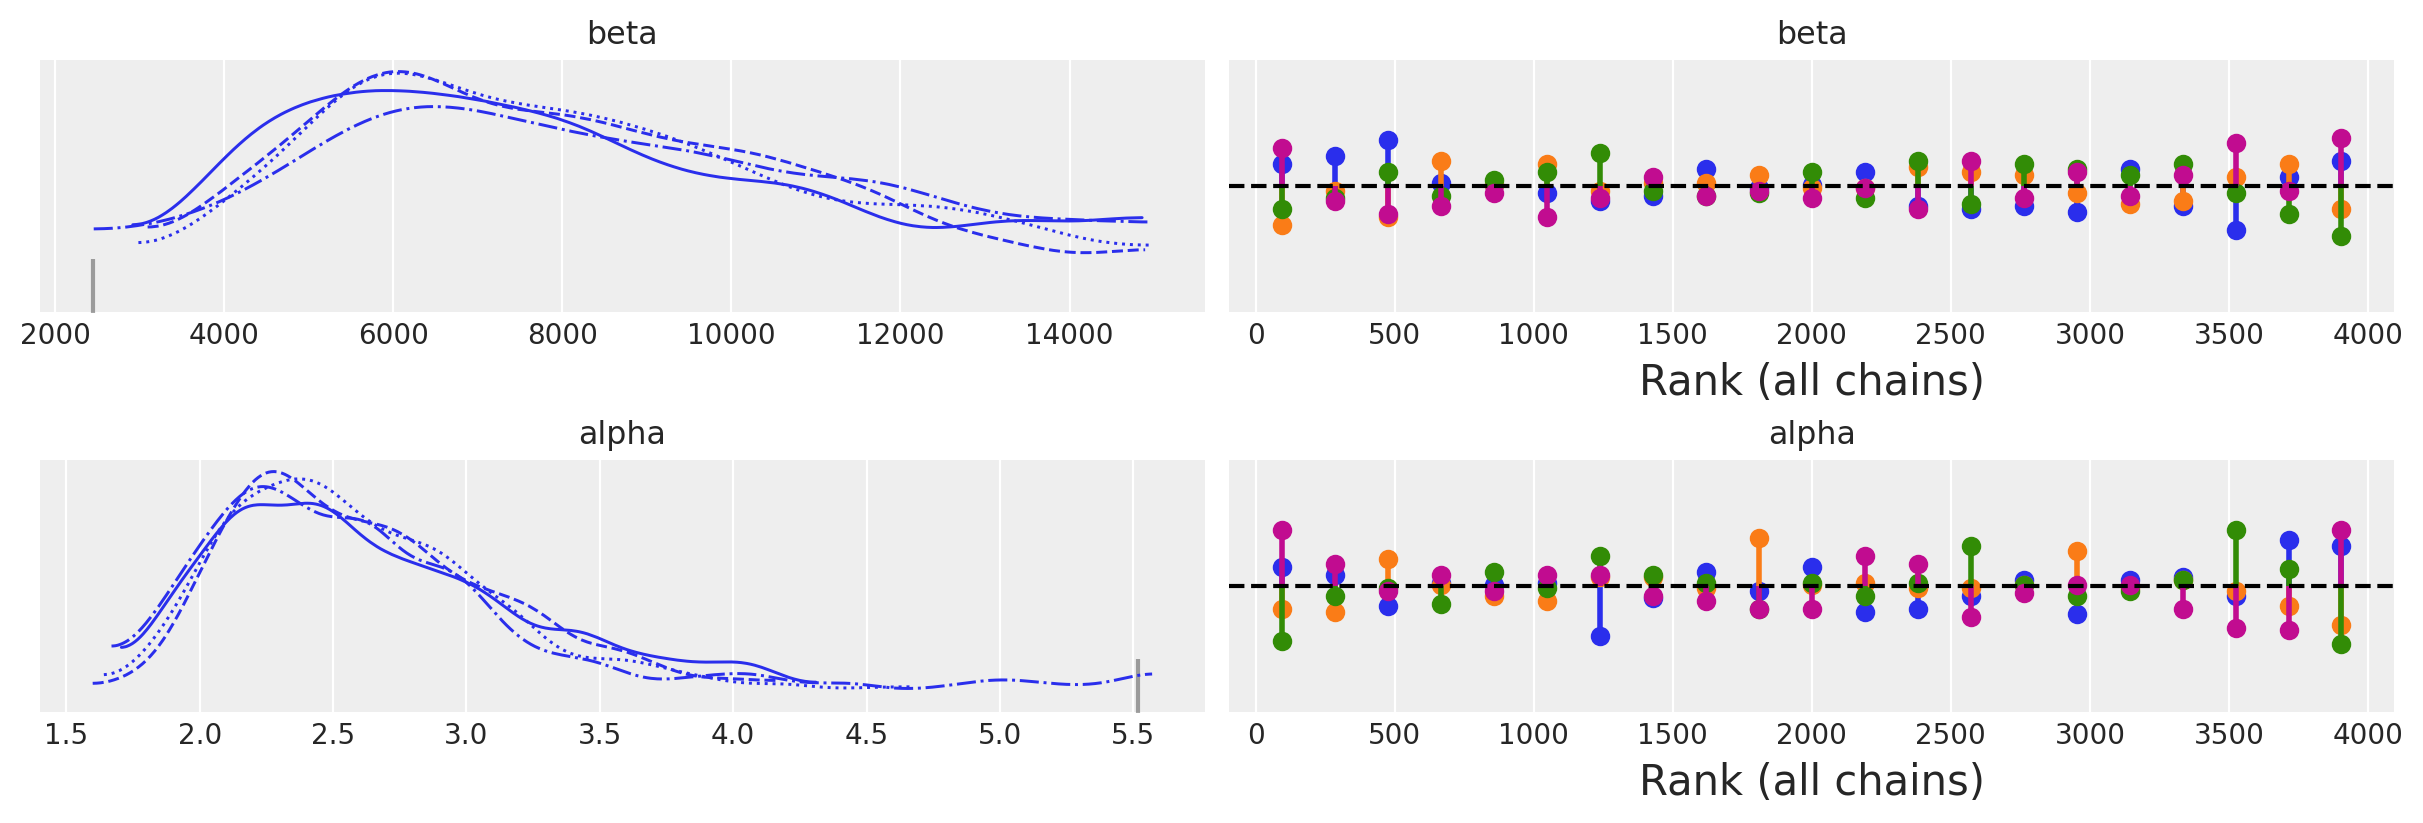

In [22]:
az.plot_trace(idata, kind="rank_vlines");

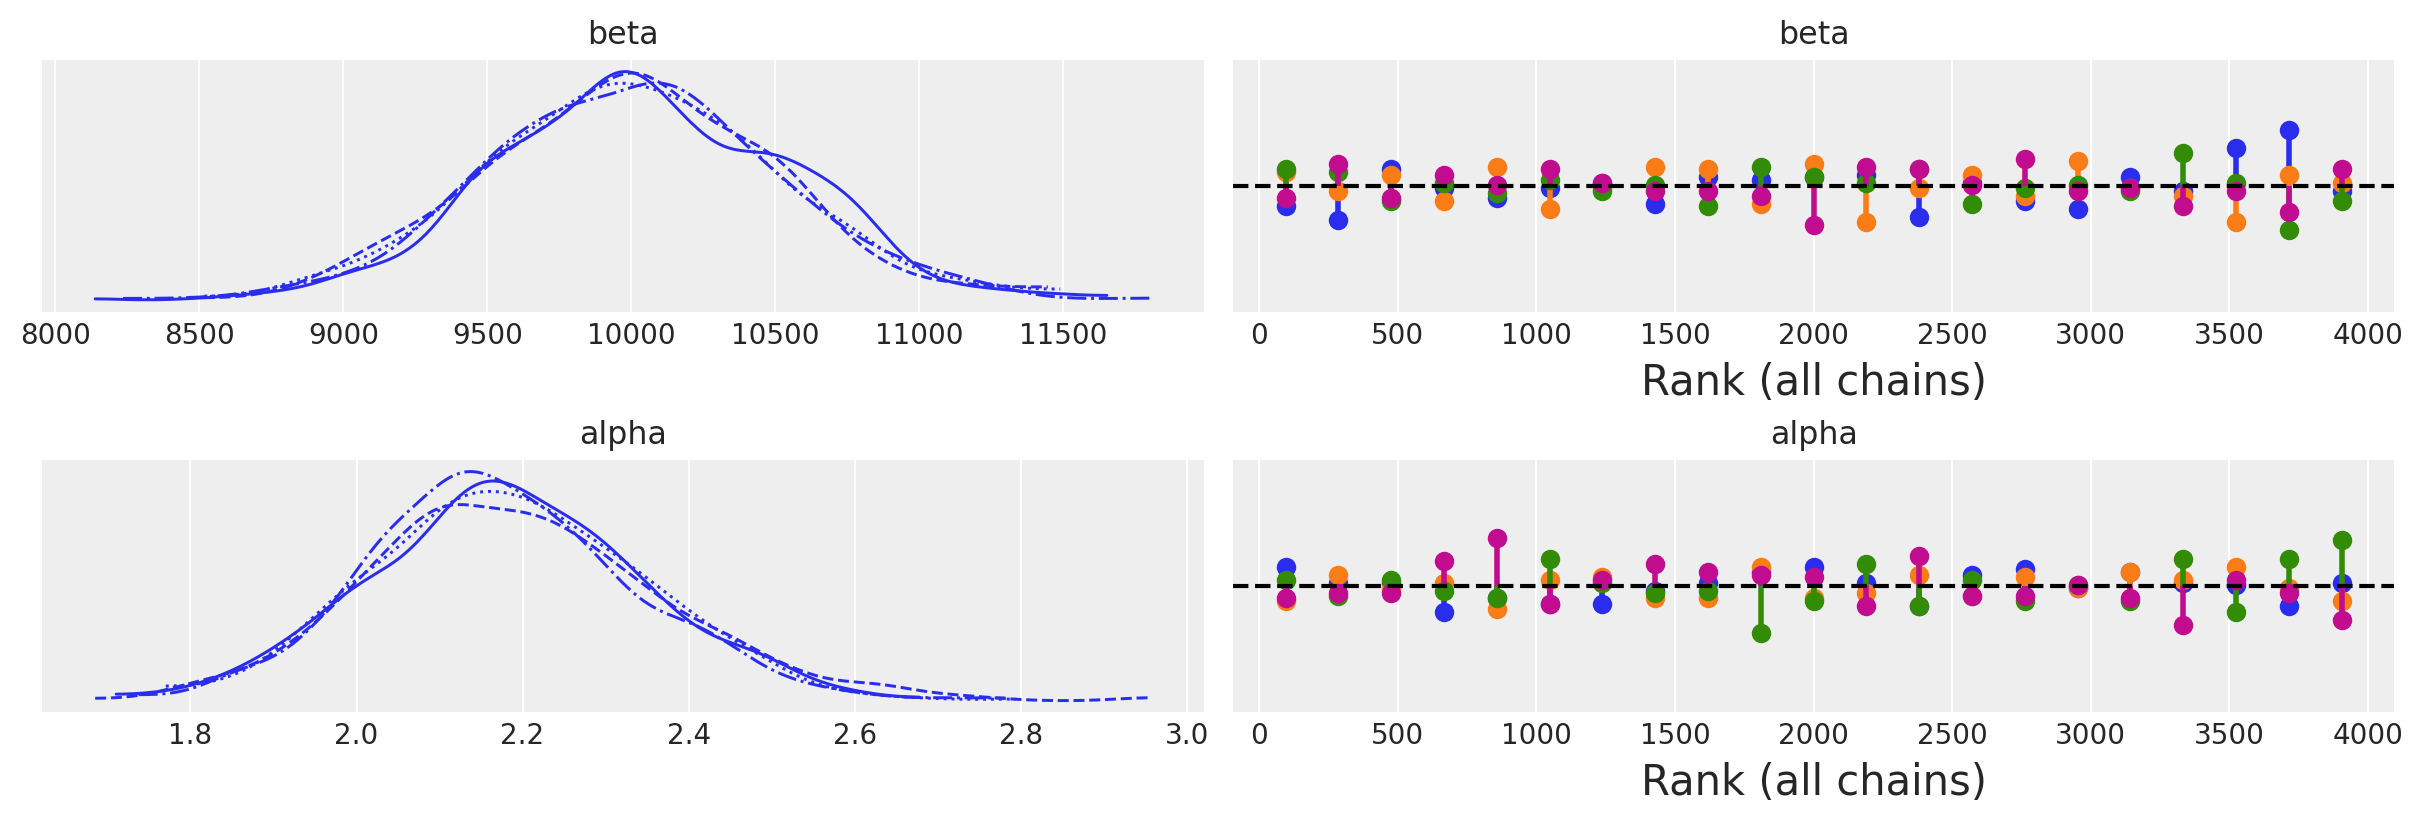

In [23]:
az.plot_trace(idata_informative, kind="rank_vlines");

In [24]:
az.summary(idata)

mean         sd     hdi_3%     hdi_97%  mcse_mean  mcse_sd  \
beta  8149.83500 2916.37800 3479.92900 13787.44700  111.29300 78.72900   
alpha    2.62600    0.55800    1.77900     3.63100    0.03000  0.02500   

       ess_bulk  ess_tail   r_hat  
beta  612.00000 371.00000 1.01000  
alpha 616.00000 353.00000 1.01000

In [25]:
az.summary(idata_informative)

mean        sd     hdi_3%     hdi_97%  mcse_mean  mcse_sd  \
beta  10011.90100 506.48900 9046.46200 10948.49500   11.79200  8.36800   
alpha     2.18200   0.16600    1.88700     2.50400    0.00400  0.00300   

        ess_bulk   ess_tail   r_hat  
beta  1850.00000 2056.00000 1.00000  
alpha 2206.00000 1788.00000 1.00000

/var/folders/99/gp2xl6x513s0tvl3cx79zf7m0000gn/T/ipykernel_6497/2035121382.py:1: FutureWarning: extract_dataset has been deprecated, please use extract
  joint_draws = az.extract_dataset(idata, group="posterior", num_samples=1000)[
/var/folders/99/gp2xl6x513s0tvl3cx79zf7m0000gn/T/ipykernel_6497/2035121382.py:7: FutureWarning: extract_dataset has been deprecated, please use extract
  joint_draws_informative = az.extract_dataset(


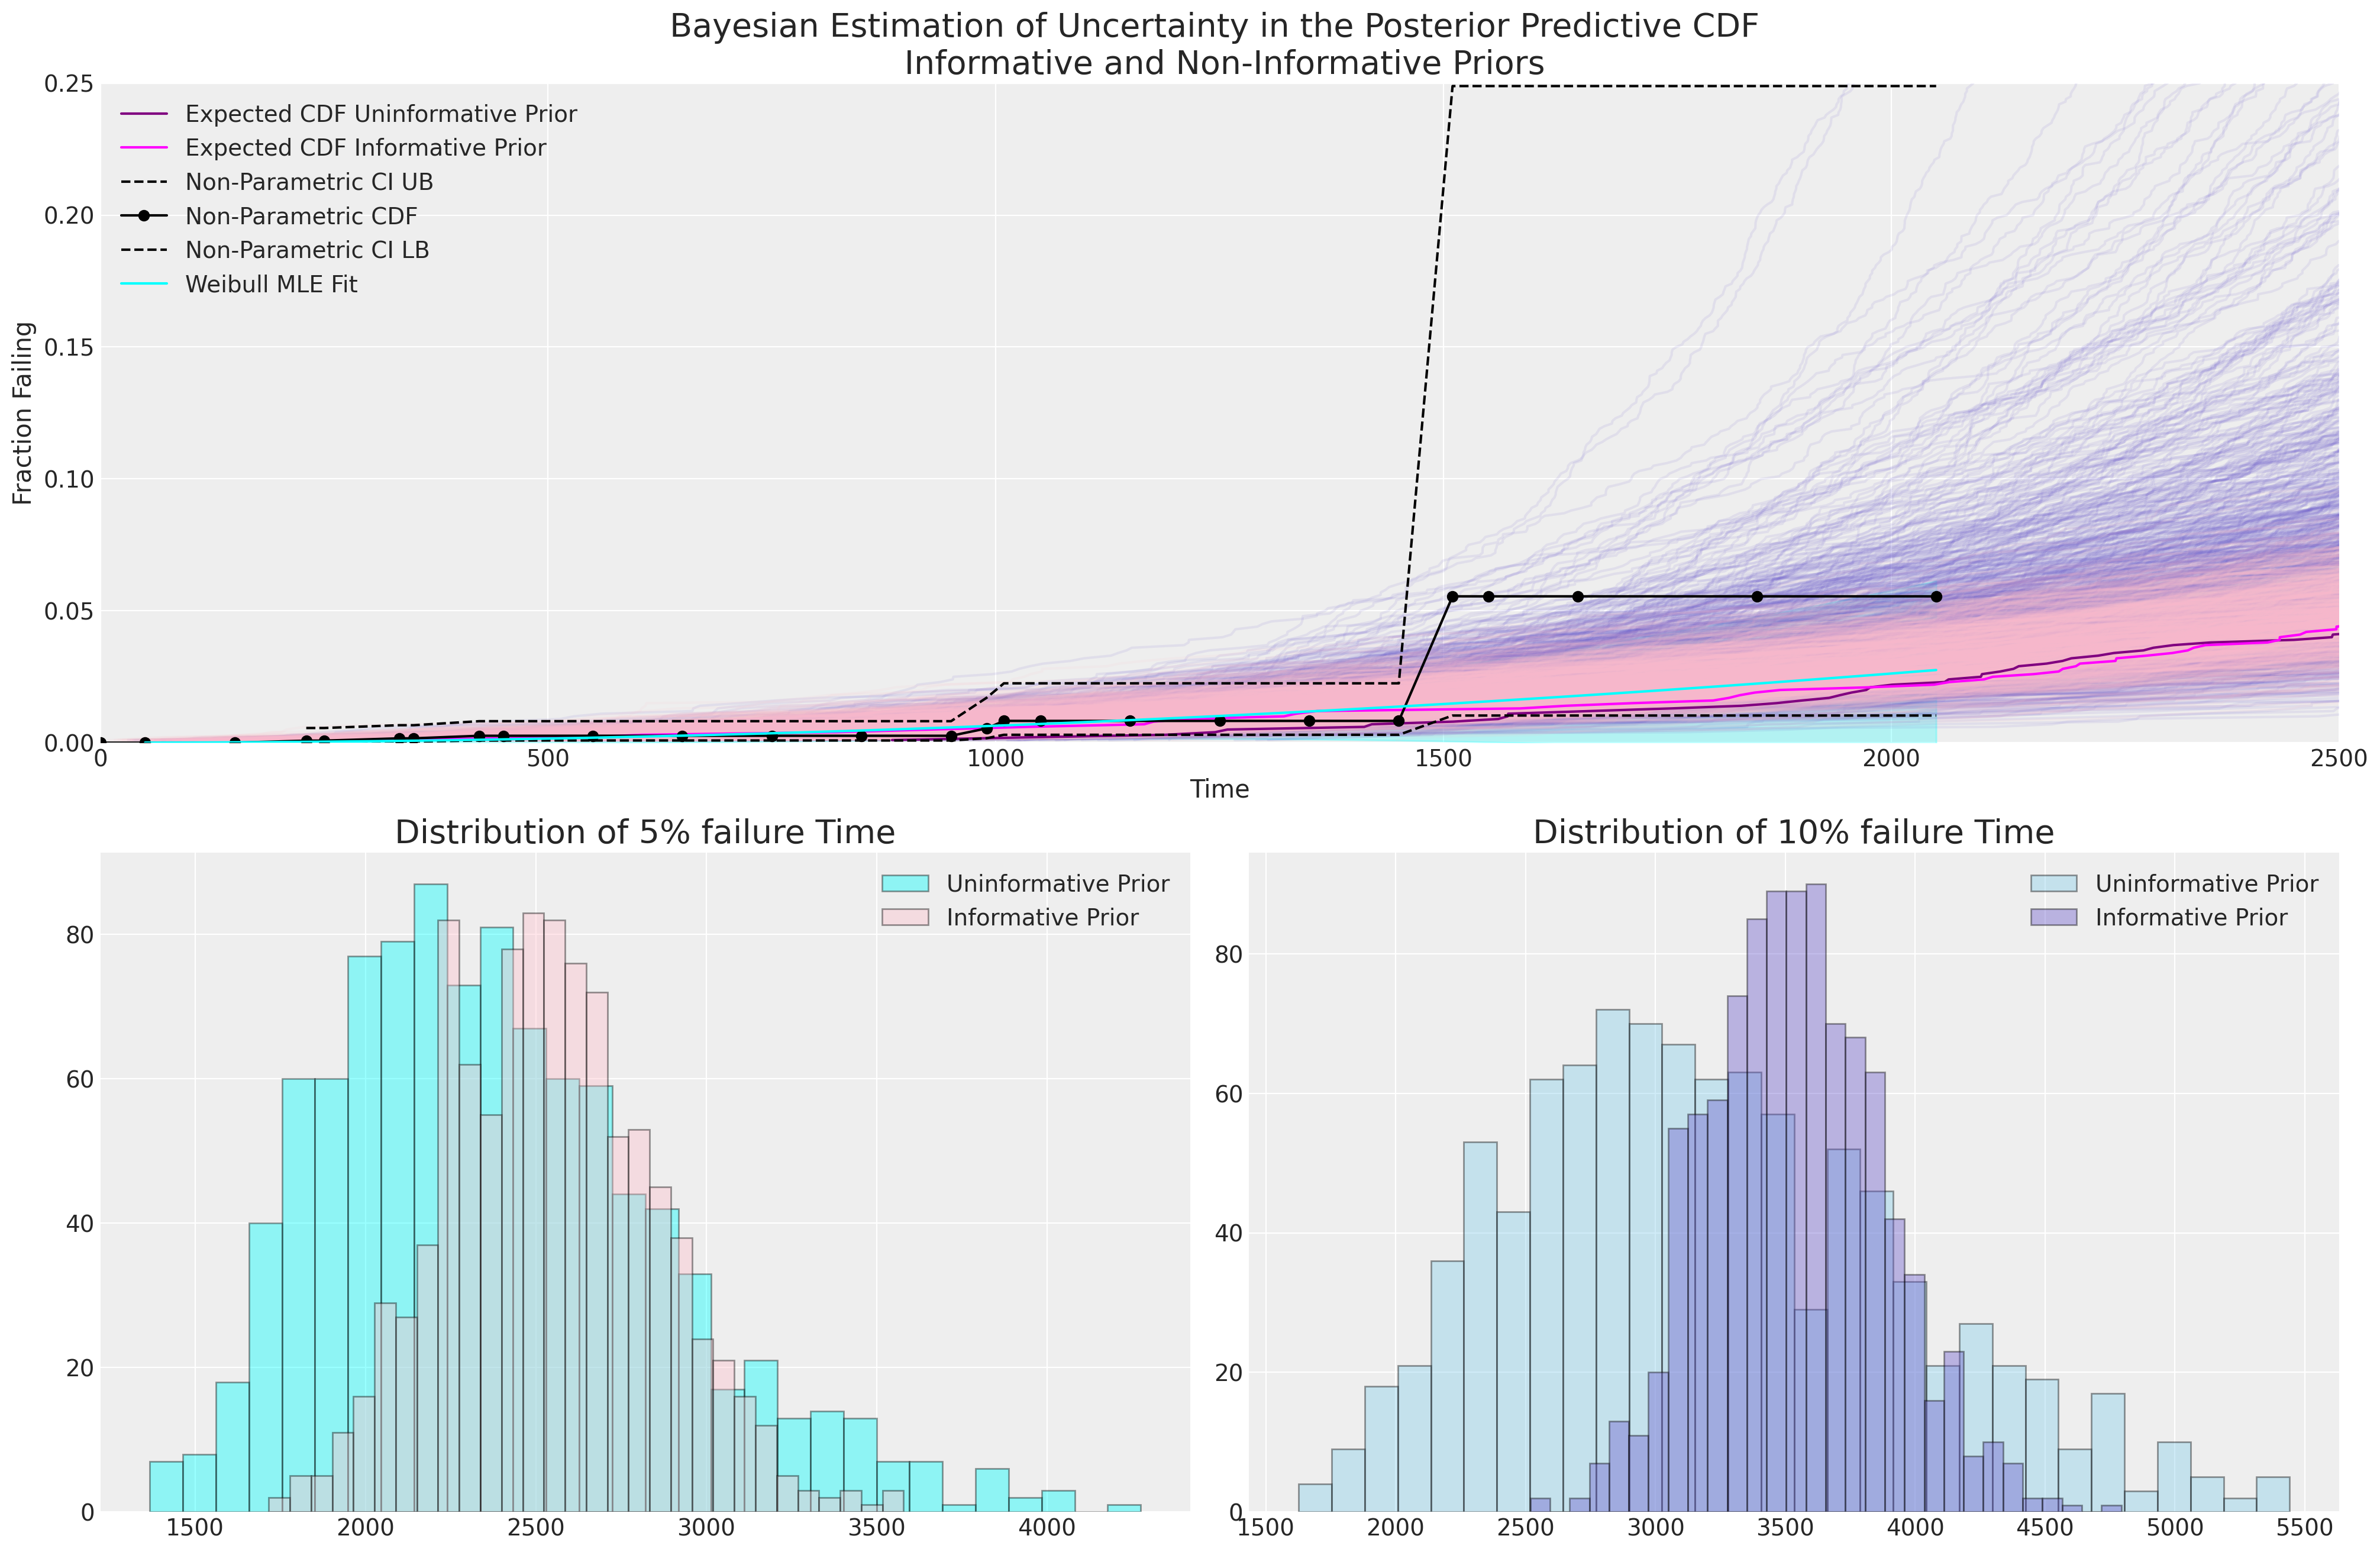

In [26]:
joint_draws = az.extract_dataset(idata, group="posterior", num_samples=1000)[
    ["alpha", "beta"]
].to_dataframe()
alphas = joint_draws["alpha"].values
betas = joint_draws["beta"].values

joint_draws_informative = az.extract_dataset(
    idata_informative, group="posterior", num_samples=1000
)[["alpha", "beta"]].to_dataframe()
alphas_informative = joint_draws_informative["alpha"].values
betas_informative = joint_draws_informative["beta"].values

mosaic = """AAAA
            BBCC"""
fig, axs = plt.subplot_mosaic(mosaic=mosaic, figsize=(20, 13))
axs = [axs[k] for k in axs.keys()]
ax = axs[0]
ax1 = axs[2]
ax2 = axs[1]
hist_data = []
for i in range(1000):
    draws = pm.draw(pm.Weibull.dist(alpha=alphas[i], beta=betas[i]), 1000)
    qe, pe = ecdf(draws)
    lkup = dict(zip(pe, qe))
    hist_data.append([lkup[0.1], lkup[0.05]])
    ax.plot(qe, pe, color="slateblue", alpha=0.1)
hist_data_info = []
for i in range(1000):
    draws = pm.draw(pm.Weibull.dist(alpha=alphas_informative[i], beta=betas_informative[i]), 1000)
    qe, pe = ecdf(draws)
    lkup = dict(zip(pe, qe))
    hist_data_info.append([lkup[0.1], lkup[0.05]])
    ax.plot(qe, pe, color="pink", alpha=0.1)
hist_data = pd.DataFrame(hist_data, columns=["p10", "p05"])
hist_data_info = pd.DataFrame(hist_data_info, columns=["p10", "p05"])
draws = pm.draw(pm.Weibull.dist(alpha=np.mean(alphas), beta=np.mean(betas)), 1000)
qe, pe = ecdf(draws)
ax.plot(qe, pe, color="purple", label="Expected CDF Uninformative Prior")
draws = pm.draw(
    pm.Weibull.dist(alpha=np.mean(alphas_informative), beta=np.mean(betas_informative)), 1000
)
qe, pe = ecdf(draws)
ax.plot(qe, pe, color="magenta", label="Expected CDF Informative Prior")
ax.plot(
    actuarial_table_bearings["t"],
    actuarial_table_bearings["logit_CI_95_ub"],
    "--",
    label="Non-Parametric CI UB",
    color="black",
)
ax.plot(
    actuarial_table_bearings["t"],
    actuarial_table_bearings["F_hat"],
    "-o",
    label="Non-Parametric CDF",
    color="black",
    alpha=1,
)
ax.plot(
    actuarial_table_bearings["t"],
    actuarial_table_bearings["logit_CI_95_lb"],
    "--",
    label="Non-Parametric CI LB",
    color="black",
)
ax.set_xlim(0, 2500)
ax.set_title(
    "Bayesian Estimation of Uncertainty in the Posterior Predictive CDF \n Informative and Non-Informative Priors",
    fontsize=20,
)
ax.set_ylabel("Fraction Failing")
ax.set_xlabel("Time")
ax1.hist(
    hist_data["p10"], bins=30, ec="black", color="skyblue", alpha=0.4, label="Uninformative Prior"
)
ax1.hist(
    hist_data_info["p10"],
    bins=30,
    ec="black",
    color="slateblue",
    alpha=0.4,
    label="Informative Prior",
)
ax1.set_title("Distribution of 10% failure Time", fontsize=20)
ax1.legend()
ax2.hist(
    hist_data["p05"], bins=30, ec="black", color="cyan", alpha=0.4, label="Uninformative Prior"
)
ax2.hist(
    hist_data_info["p05"], bins=30, ec="black", color="pink", alpha=0.4, label="Informative Prior"
)
ax2.legend()
ax2.set_title("Distribution of 5% failure Time", fontsize=20)
wbf = WeibullFitter().fit(item_period_bearing_cage["t"] + 1e-25, item_period_bearing_cage["failed"])
wbf.plot_cumulative_density(ax=ax, color="cyan", label="Weibull MLE Fit")
ax.legend()
ax.set_ylim(0, 0.25);

We can see here how the Bayesian uncertainty estimates driven by our deliberately vague priors encompasses more uncertainty than our MLE fit and the uninformative prior implies a wider predictive distribution for the 5% and 10% failure times. The Bayesian model with uninformative priors seems to do a better job of capturing the uncertainty in the non-parametric estimates of our CDF, but without more information it's hard to tell which is the more appropriate model.

The concrete estimates of failure percentage over time of each model fit are especially crucial in a situation where we have sparse data. It is a meaningful sense check that we can consult with subject matter experts about how plausible the expectation and range for the 10% failure time is for their product.

## Predicting the Number of Failures in an Interval

Because our data on observed failures is extremely sparse, we have to be very careful about extrapolating beyond the observed range of time, but we can ask about the predictable number of failures in the lower tail of our cdf. This provides another view on this data which can be helpful for discussing with subject matters experts. 

### The Plugin Estimate

Imagine we want to know how many bearings will fail between 150 and 600 hours based of service. We can calculate this based on the estimated CDF and number of new future bearings. We first calculate: 

$$ \hat{\rho} = \dfrac{\hat{F}(t_1) - \hat{F}(t_0)}{1 - \hat{F}(t_0)} $$

to establish a probability for the failure occurring in the interval and then a point prediction for the number of failures in the interval is given by `risk_set`*$\hat{\rho}$.

In [27]:
mle_fit = weibull_min(c=2, scale=10_000)
rho = mle_fit.cdf(600) - mle_fit.cdf(150) / (1 - mle_fit.cdf(150))
print("Rho:", rho)
print("N at Risk:", 1700)
print("Expected Number Failing in between 150 and 600 hours:", 1700 * rho)
print("Lower Bound 95% PI :", binom(1700, rho).ppf(0.05))
print("Upper Bound 95% PI:", binom(1700, rho).ppf(0.95))

Rho: 0.0033685024546080927
N at Risk: 1700
Expected Number Failing in between 150 and 600 hours: 5.7264541728337575
Lower Bound 95% PI : 2.0
Upper Bound 95% PI: 10.0


### Applying the Same Procedure on the Bayesian Posterior

We'll use the posterior predictive distribution of the uniformative model. We show here how to derive the uncertainty in the estimates of the 95% prediction interval for the number of failures in a time interval.

In [28]:
def PI_failures(joint_draws, lp, up, n_at_risk):
    records = []
    alphas = joint_draws["alpha"].values
    betas = joint_draws["beta"].values
    for i in range(len(joint_draws)):
        fit = weibull_min(c=alphas[i], scale=betas[i])
        rho = fit.cdf(up) - fit.cdf(lp) / (1 - fit.cdf(lp))
        lb = binom(n_at_risk, rho).ppf(0.05)
        ub = binom(n_at_risk, rho).ppf(0.95)
        point_prediction = n_at_risk * rho
        records.append([alphas[i], betas[i], rho, n_at_risk, lb, ub, point_prediction])
    return pd.DataFrame(
        records, columns=["alpha", "beta", "rho", "n_at_risk", "lb", "ub", "expected"]
    )


output_df = PI_failures(joint_draws, 150, 600, 1700)
output_df

alpha        beta     rho  n_at_risk      lb      ub  expected
0   2.50110  7025.44270 0.00206       1700 1.00000 7.00000   3.49720
1   3.09885  4809.11430 0.00156       1700 0.00000 6.00000   2.64883
2   3.58740  3868.36817 0.00124       1700 0.00000 5.00000   2.10669
3   3.37618  4190.95286 0.00140       1700 0.00000 5.00000   2.37713
4   3.48757  4506.50295 0.00088       1700 0.00000 4.00000   1.48855
..      ...         ...     ...        ...     ...     ...       ...
995 1.94637 13347.02041 0.00222       1700 1.00000 7.00000   3.77929
996 1.94371 13428.60267 0.00221       1700 1.00000 7.00000   3.76477
997 2.15506 12434.43599 0.00138       1700 0.00000 5.00000   2.34731
998 2.84756  7560.95577 0.00072       1700 0.00000 3.00000   1.22543
999 2.95086  4513.61352 0.00255       1700 1.00000 8.00000   4.33011

[1000 rows x 7 columns]

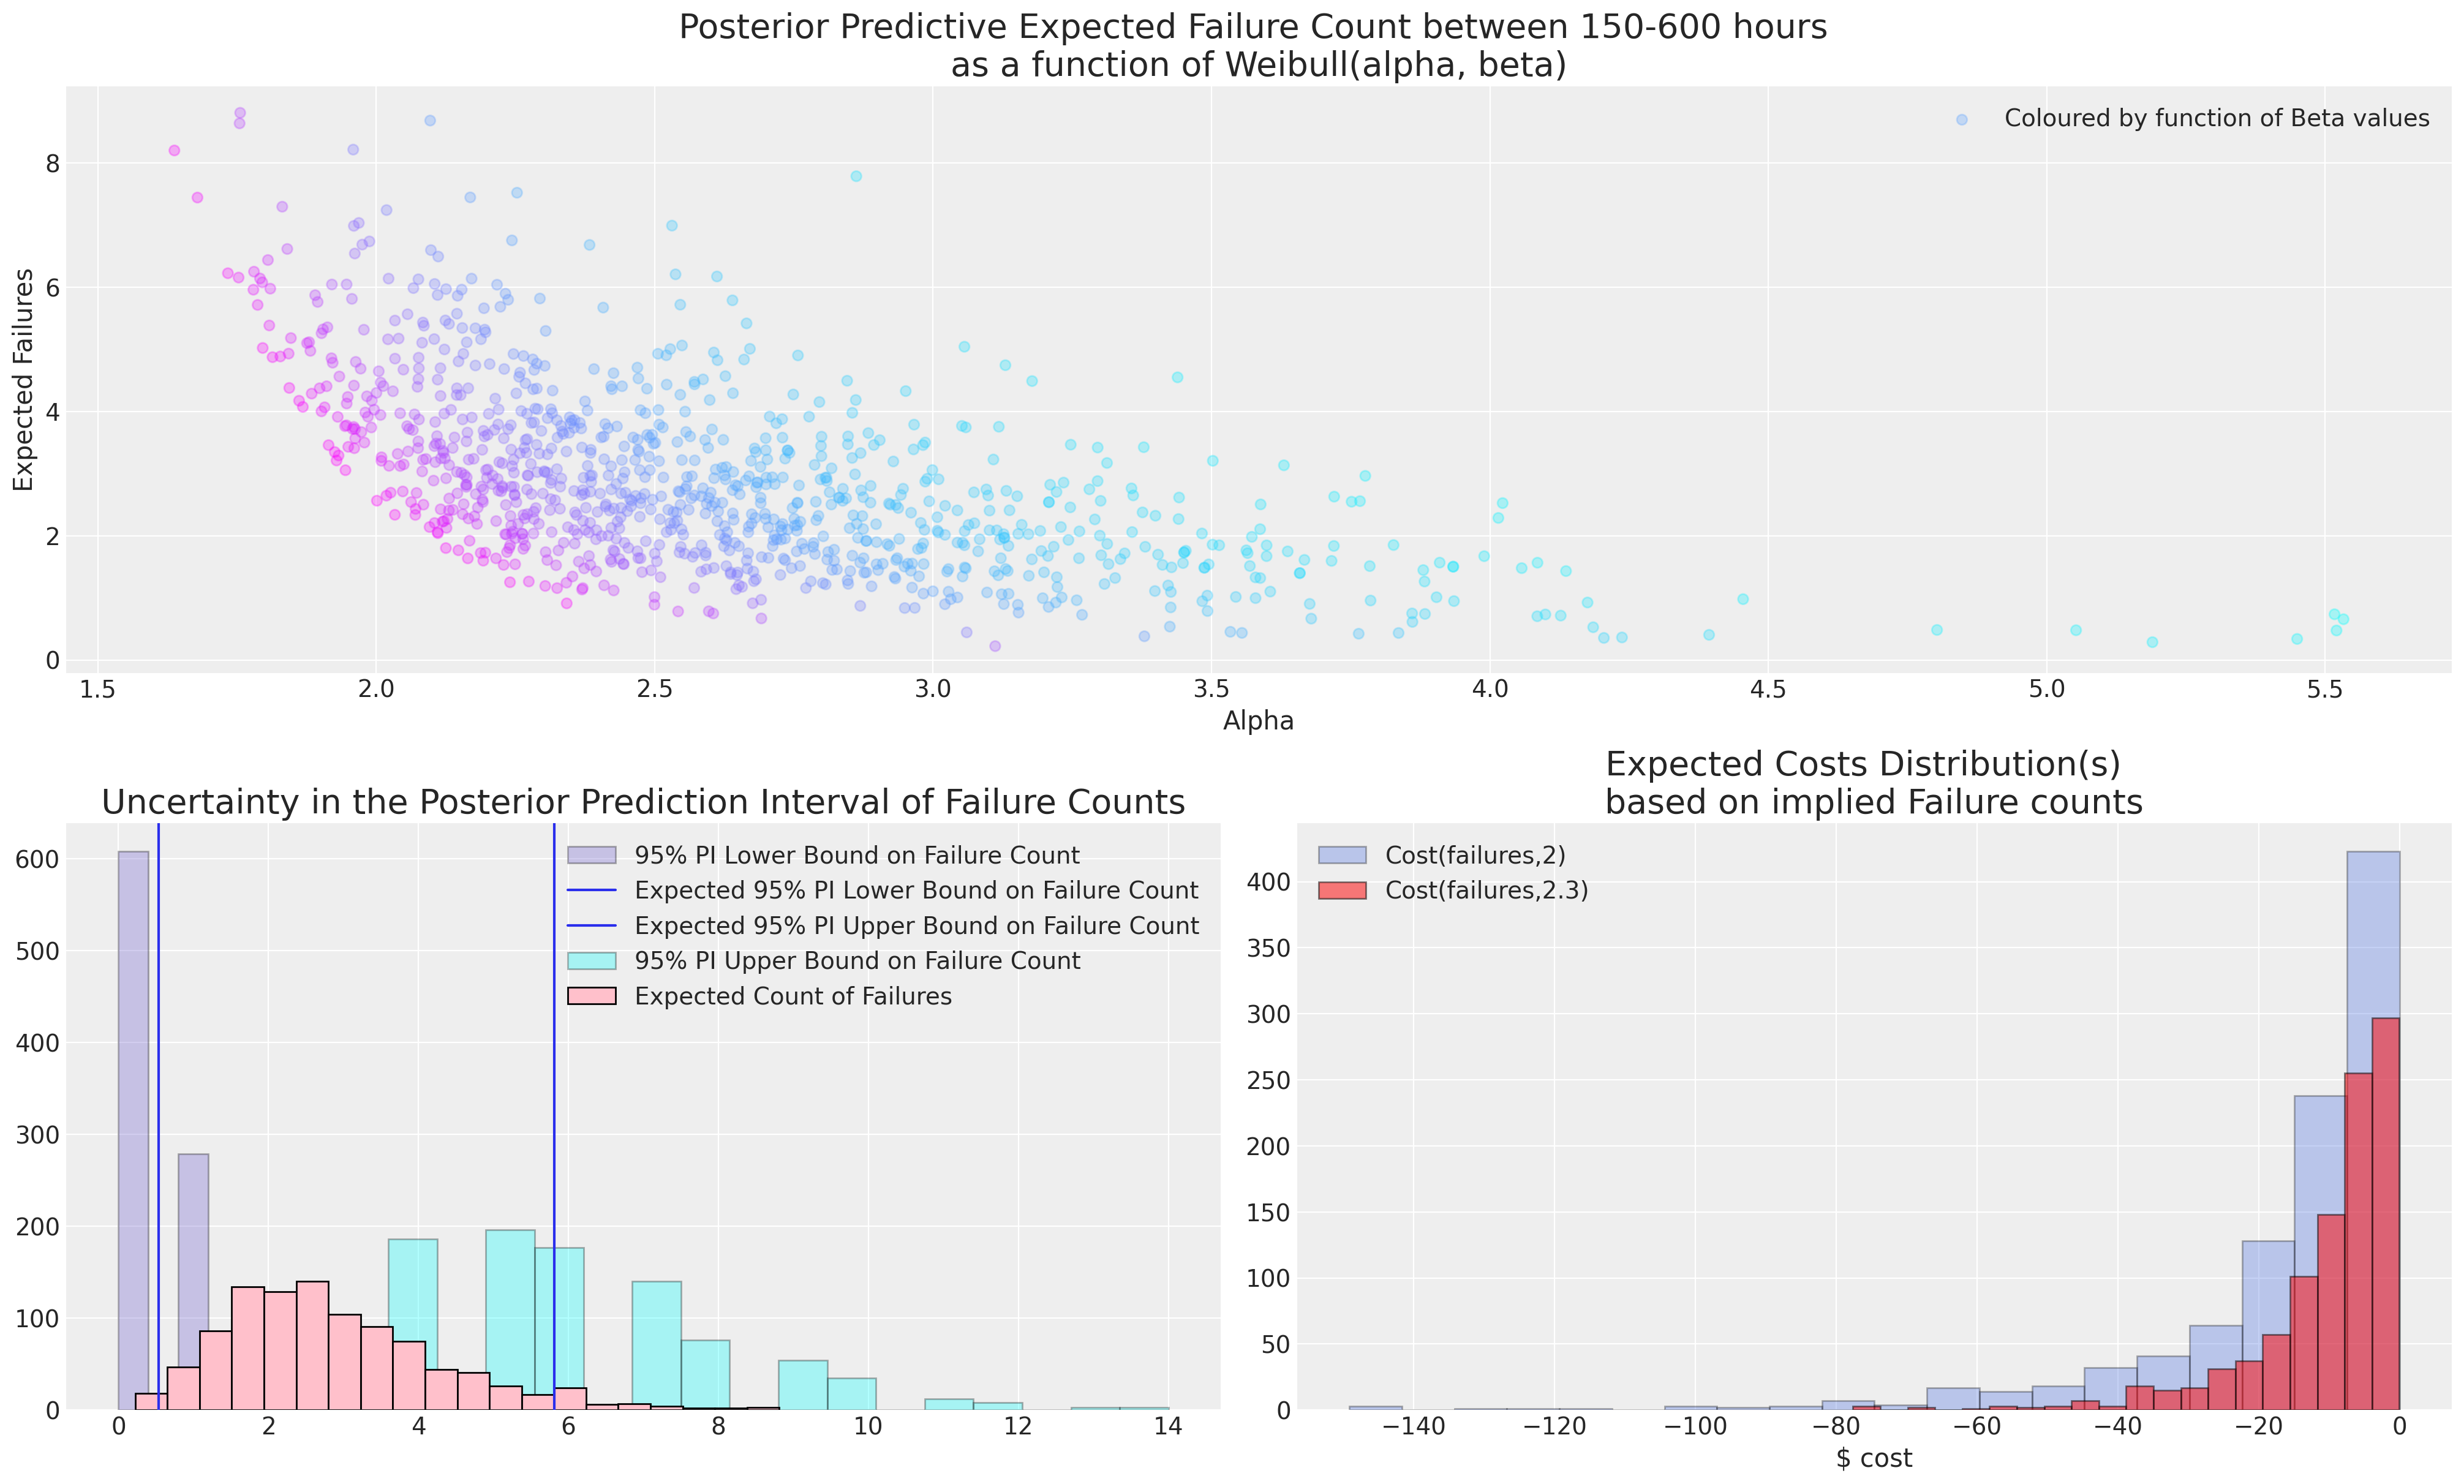

In [29]:
def cost_func(failures, power):
    ### Imagined cost function for failing item e.g. refunds required
    return -np.power(failures, power)


mosaic = """AAAA
            BBCC"""
fig, axs = plt.subplot_mosaic(mosaic=mosaic, figsize=(20, 12))
axs = [axs[k] for k in axs.keys()]
ax = axs[0]
ax1 = axs[1]
ax2 = axs[2]

ax.scatter(
    output_df["alpha"],
    output_df["expected"],
    c=output_df["beta"],
    cmap=cm.cool,
    alpha=0.3,
    label="Coloured by function of Beta values",
)
ax.legend()
ax.set_ylabel("Expected Failures")
ax.set_xlabel("Alpha")
ax.set_title(
    "Posterior Predictive Expected Failure Count between 150-600 hours \nas a function of Weibull(alpha, beta)",
    fontsize=20,
)

ax1.hist(
    output_df["lb"],
    ec="black",
    color="slateblue",
    label="95% PI Lower Bound on Failure Count",
    alpha=0.3,
)
ax1.axvline(output_df["lb"].mean(), label="Expected 95% PI Lower Bound on Failure Count")
ax1.axvline(output_df["ub"].mean(), label="Expected 95% PI Upper Bound on Failure Count")
ax1.hist(
    output_df["ub"],
    ec="black",
    color="cyan",
    label="95% PI Upper Bound on Failure Count",
    bins=20,
    alpha=0.3,
)
ax1.hist(
    output_df["expected"], ec="black", color="pink", label="Expected Count of Failures", bins=20
)
ax1.set_title("Uncertainty in the Posterior Prediction Interval of Failure Counts", fontsize=20)
ax1.legend()

ax2.set_title("Expected Costs Distribution(s)  \nbased on implied Failure counts", fontsize=20)
ax2.hist(
    cost_func(output_df["expected"], 2.3),
    label="Cost(failures,2)",
    color="royalblue",
    alpha=0.3,
    ec="black",
    bins=20,
)
ax2.hist(
    cost_func(output_df["expected"], 2),
    label="Cost(failures,2.3)",
    color="red",
    alpha=0.5,
    ec="black",
    bins=20,
)
ax2.set_xlabel("$ cost")
ax2.legend()

The choice of model in such cases is crucial. The decision about which failure profile is apt has to be informed by a subject matter expert because extrapolation from such sparse data is always risky. An understanding of the uncertainty is crucial if real costs attach to the failures and the subject matter expert is usually better placed to tell if you 2 or 7 failures can be plausibly expected within 600 hours of service. 

# Conclusion

We've seen how to analyse and model reliability from both a frequentist and Bayesian perspective and compare against the non-parametric estimates. We've shown how prediction intervals can be derived for a number of key statistics by both a bootstrapping and a bayesian approach. We've seen approaches to calibrating these prediction intervals through re-sampling methods and informative prior specification. These views on the problem are complementary and the choice of technique which is appropriate should be driven by factors of the questions of interest, not some ideological commitment. 

In particular we've seen how the MLE fits to our bearings data provide a decent first guess approach to establishing priors in the Bayesian analysis. We've also seen how subject matter expertise can be elicited by deriving key quantities from the implied models and subjecting these implications to scrutiny. The choice of Bayesian prediction interval is calibrated to our priors expectations, and where we have none - we can supply vague or non-informative priors. The implications of these priors can again be checked and analysed against an appropriate cost function.

## Authors

Nathaniel Forde

## References

:::{bibliography}
:filter: docname in docnames
:::

## Watermark

In [30]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Sat Jan 07 2023

Python implementation: CPython
Python version       : 3.9.0
IPython version      : 8.4.0

pytensor: 2.8.11

arviz     : 0.14.0
numpy     : 1.23.4
matplotlib: 3.6.1
pymc      : 5.0.1
pandas    : 1.5.1
sys       : 3.9.0 (default, Nov 15 2020, 06:25:35) 
[Clang 10.0.0 ]

Watermark: 2.3.1



:::{include} ../page_footer.md
:::